# EEE 571 Project - Power System Transients Analysis

## Generative AI Use Statement

For Academic Integrity, Grok 4.1 has been used in the preparation of this report.

## Introduction

This Jupyter notebook serves as a computational report for the EEE 571 project on electrical transients in a 3-phase power system. The system includes a generator, circuit breaker, shell-type transformer, and a 10-mile 525 kV transmission line. We will perform analytical calculations for Step 1 (one-line diagram and data preparation), using symbolic computations with SymPy for derivations and numerical evaluations with NumPy. Matplotlib will be used for visualizations, such as impedance triangles and power phasors.

Key parameters (customized with student ID factor *=7):
- Generator: 1559 MVA, 24 kV LL, 60 Hz, wye-grounded, sub-transient reactance X'' = 27 % pu.
- Transformer: 1550 MVA, 24 kV $\Delta$ / 525 kV Y-grounded, through Z = 17 % pu, X/R = 5, exciting current = 1 % rated, LV capacitance = 5000 pF/phase to ground. Neglect saturation/core losses.
- Line: 10 miles, positive/zero sequence parameters as given.
- Load (Part 4): 700 MVA at 0.95 lagging pf, constant impedance.

All calculations are on per-phase, 60 Hz ($\omega = 377 rad/s$) basis. Steady-state nominal: HV ph-gnd V = 525 / $\sqrt{3} \approx$ 303 kV RMS.

## Single Line Diagram

The following is a single - line diagram of the system as described in the Project Instructions.  Values entered into each item were calculated based on my student ID as per Project Instructions.

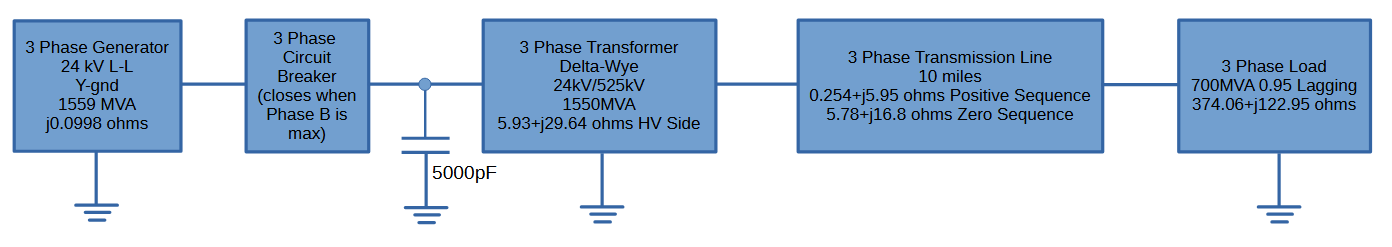

## Import Libraries

We import necessary libraries.

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Arc
import pandas as pd
from scipy.integrate import odeint
from scipy import signal  # For RRRV calc

# Definitions

## Define Symbols

Symbols are defined so that they can be used in Sympy for formula display.

In [2]:
# SymPy symbols for derivations
S_gen, V_gen_LL, X_pp_pu, S_tr, V_tr_LV, V_tr_HV, Z_tr_pu, XR_ratio = sp.symbols('S_gen V_gen_LL X_pp_pu S_tr V_tr_LV V_tr_HV Z_tr_pu XR_ratio')
R_pu, X_pu, omega = sp.symbols('R_pu X_pu omega')
S_load_sym, pf_sym = sp.symbols('S_load pf')

## General Definitions and Physical Constants

### Speed of Light in a Vacuum (approx) in $\left[\frac{miles}{sec}\right]$:

In [3]:
v_light_mi_per_s = 186000  # mi/s 

### Meters per Mile in $\left[\frac{meters}{mile}\right]$:

In [4]:
meters_per_mile = 1609.3 # meters / mil

## Define Circuit Numerical Parameters

### Generator

#### Generator Frequency in $\left[Hz\right]$:

In [5]:
f = 60  # Hz

#### Calculate Generator Frequency in $\left[\frac{rad}{sec}\right]$:

In [6]:
omega_num = 2 * np.pi * f

In [7]:
print(f"Generator frequency is {omega_num:0.2f} rad/sec")

Generator frequency is 376.99 rad/sec


#### Generator Power in $\left[VA\right]$:

In [8]:
S_gen_num = 1559e6  # VA

#### Generator Line to Line Voltage in $\left[V\right]$:

In [9]:
V_gen_LL_num = 24e3  # V

#### Generator Sub-Transient Reactance in $\left[per-unit\right]$:

In [10]:
X_pp_pu_num = 0.27

### Transformer

#### Power Rating of Transformer in $\left[VA\right]$:

In [11]:
S_tr_num = 1550e6  # VA

#### Input Voltage of Transformer (Low Voltage Side) in $\left[V\right]$:

In [12]:
V_tr_LV_num = 24e3  # V

#### Output Voltage of Transformer (High Voltage Side) in $\left[V\right]$:

In [13]:
V_tr_HV_num = 525e3  # V

#### Calculate Transformer Peak Output Phase to Neutral Voltage in $\left[V\right]$:

In [14]:
V_peak_ph = np.sqrt(2) * (V_tr_HV_num / np.sqrt(3))  # HV ph-gnd crest

In [15]:
print(f"The transformer peak phase to ground voltage is {V_peak_ph:0.4f} V")

The transformer peak phase to ground voltage is 428660.7050 V


#### Calculate Transformer Output Phase to Neutral RMS Voltage (High Side) in $\left[V\;rms\right]$:

In [16]:
V_ph_HV_num = V_tr_HV_num / np.sqrt(3)

In [17]:
print(f"The transformer phase to ground voltage is {V_ph_HV_num:0.4f} V rms")

The transformer phase to ground voltage is 303108.8913 V rms


#### Through Impedance of Transformer (Based on Student ID) in $\left[per-unit \right]$:

In [18]:
Z_tr_pu_num = 0.17

#### Ratio of Reactance to Resistance of Transformer in $\left[unitless \right]$:

In [19]:
XR_ratio_num = 5

#### Magnetization Current of Transformer Primary (as a percentage of rated current, converted into multiplying factor) in $\left[unitless\right]$:

In [20]:
I_exc_pct = 0.01

#### Capacitance of Each Winding in $\left[F\right]$:

In [21]:
C_lv_num = 5000e-12  # F/phase

### Transmission Line

#### Length of Transmission Line in $\left[miles\right]$:

In [22]:
line_length_mi = 10  # miles

#### Transmission Line Sequence Characteristics

These parameters describe the electrical characteristics per mile of the 525 kV extra-high-voltage (EHV) transmission line in your project. They are given for two sequence networks: positive sequence (for balanced conditions and unbalanced faults' positive components) and zero sequence (for ground faults and unbalanced currents returning via earth/ground).

*Key Parameters Breakdown*

- **R** (Ω per mile): Series resistance per phase/conductor. Includes conductor material losses (copper or aluminum $I^2R$ heating). Zero-sequence $R$ is higher because the ground-return path (through earth) adds resistance.

- **X** (Ω per mile): Series reactance per phase, mainly inductive. 
  $$
  X = \omega L, \quad \omega = 2\pi f \approx 377~\text{rad/s} \text{ at } f = 60~\text{Hz},
  $$
  where $L$ comes from magnetic flux linkage. Capacitance in series is neglected. Zero-sequence $X$ is higher because the ground path increases the effective inductance.

- **Y** (micromhos per mile): Shunt admittance per mile to neutral/ground. Write
  $$
  Y = G + jB,
  $$
  with $G \approx 0$, so $Y \approx j\omega C$, where $B = \omega C$ is the capacitive susceptance from line-to-ground capacitance.

  “Micromho” is an older unit:  
  $1~\text{mho} = 1~\text{S}$ (siemens), so  
  $1~\text{micromho} = 1~\mu\text{S} = 10^{-6}~\text{S}$.

  - **Zero-sequence:**  
    $Y_0 = 5.0~\mu\text{S/mi} = 5.0 \times 10^{-6}~\text{S/mi}$  
    (lower effective capacitance due to ground return geometry).

  - **Positive-sequence:**  
    $Y_1 = 7.034~\mu\text{S/mi} = 7.034 \times 10^{-6}~\text{S/mi}$  
    (higher, mainly from phase-to-phase plus phase-to-ground capacitance).

|Sequence |R ($\Omega$/mi) |X ($\Omega$/mi) |Y ($\mu$S/mi) |Physical Meaning|
| --- | --- | --- | --- | --- |    
|Zero |0.578 |1.68 |5.0 |Unbalanced/ground faults: High R/X from earth return (3x neutral + mutual effects); low Y (reduced C to ground).|
|Positive |0.0254 |0.595 |7.034 |Balanced operation: Low R/X (conductor only); high Y (line capacitance causes Ferranti effect in open lines).|

Why Different for Sequences?

- Positive Sequence: Represents normal balanced 3-phase flow. Low R/X (efficient conductor design); Y from capacitance between phases/ground, causing charging current ($I_{ch} = \frac{V Y l }{2}$, where l = length).
- Zero Sequence: For Single Line Ground faults, currents flow back via ground/neutral. Triples effective R/X (3R_earth + mutual); Y lower as capacitance paths altered by ground.

##### Zero Sequence

In [23]:
# Line per-mile parameters (zero - sequence)
R0_per_mi = 0.578  # ohm/mi zero
X0_per_mi = 1.68   # ohm/mi zero
Y0_per_mi = 5.0e-6 # S/mi zero (micromhos = uS)

##### Positive Sequence

In [24]:
# Line per-mile parameters (positive - sequence)
R1_per_mi = 0.0254 # ohm/mi pos
X1_per_mi = 0.595  # ohm/mi pos
Y1_per_mi = 7.034e-6 # S/mi pos

#### Calculate Travel Time of Signal Through Entirety of Transmission Line in $\left[\mu s\right]$:

In [25]:
tau = line_length_mi / v_light_mi_per_s * 1e6  # us one-way

In [26]:
print(f"Transmission line travel time is {tau:0.2f} microseconds")

Transmission line travel time is 53.76 microseconds


#### Surge Impedance of Transmission Line

$Z_c$ represents the effective impedance "seen" by a propagating voltage wave on the line, analogous to the impedance of a lossless transmission line that matches source and load to prevent reflections.  The formula derives from the telegraph equations for distributed-parameter lines.  For a line with series impedance per unit length $z$ $(\omega/mile)$ and shunt admittance per unit length $y$ (S/mile), the characteristic impedance is:
$$Z_c = \sqrt{\frac{z}{y}}$$

##### Input Parameters (From Project Data)
These are positive-sequence values per mile (from the document: R = 0.0254 $\Omega$/mi, X = 0.595 $\Omega$/mi, Y = 7.034 $\mu$S/mi = $7.034 \times 10^{-6}$ S/mi).

* R1_per_mi = 0.0254: Series resistance per mile ($r$, real part of $z$; includes conductor losses).
* X1_per_mi = 0.595: Series inductive reactance per mile ($\omega L = 2\pi f L$, where $f = 60$ Hz, $\omega \approx 377$ rad/s; imaginary part of $z$).
* Y1_per_mi = 7.034e-6: Shunt admittance magnitude per mile ($|y| = B = \omega C$, where $C$ is line-to-ground capacitance per mile; conductance $G \approx 0$, so $y \approx j B$).

Physically:

$z = r + j \omega L$: Models series voltage drop along the line (resistance + inductance).
$y = g + j \omega C \approx j \omega C$: Models shunt charging current (capacitance to ground; $g$ neglected as losses are small).

##### Complex Impedance Construction: (R1_per_mi + 1j * X1_per_mi)

This builds $z = r + j x$ (series impedance per mile).  <br>
Captures the inductive nature ($x \gg r$); at 60 Hz, reactance dominates.

#####  Complex Admittance Construction: (Y1_per_mi * 1j)

This builds $y = j b$, where $b = Y1_{per\_mi} = \omega C$ (shunt susceptance per mile). <br>
$Y1_{per\_mi}$ * 1j = $j \;$ Y1_per_mi (purely imaginary, capacitive). <br>
Line admittance is mostly capacitive (charging current).

##### Ratio: z / y

Computes $\frac{z}{y} = \frac{r + j x}{j b} = \frac{(r + j x) (-j)}{b} = \frac{ -j r + x }{b}$ (rationalized).
This yields a complex number with both real and imaginary parts.
Physically: Represents the "propagation impedance" squared; sqrt gives $Z_c$.

#####  Square Root: np.sqrt(...)

$Z_c = \sqrt{\frac{z}{y}} \approx \sqrt{\frac{j x}{j b}} = \sqrt{\frac{x}{b}}$ (lossless approx, since $r \ll x$, $g = 0$).

##### Real Extraction:

Takes only the real part: $Z_c \approx \Re\left( \sqrt{\frac{z}{y}} \right)$. <br>

$Z_c \approx \sqrt{\frac{L}{C}} = \sqrt{\frac{X / \omega}{Y / \omega}} = \sqrt{\frac{X}{Y}} \approx \sqrt{0.595 / 7.034e-6} \approx 291 \Omega$.

##### Calculate Transmission Line Surge Impedance $\left(Z_c\right)$ in $\left[\Omega\right]$:

In [27]:
Z_c = np.sqrt( (R1_per_mi + 1j * X1_per_mi) / (Y1_per_mi * 1j) ).real  # Approx real part

In [28]:
print(f"Transmission Line Surge Impedance Z_c ~ {Z_c:.0f} ohms")

Transmission Line Surge Impedance Z_c ~ 291 ohms


### Load

#### Load Power Consumption in $\left[VA\right]$:

In [29]:
S_load_num = 700e6  # VA

#### Load Power Factor (Lagging -> Inductive) ($cos \; \theta$) in $\left[unitless\right]$:

In [30]:
pf_lag = 0.95

#### Calculate Load Phase Angle $\left(\theta\right)$ in $\left[degrees\right]$:

In [31]:
theta_deg = np.arccos(pf_lag) * 180 / np.pi  # degrees

In [32]:
print(f"Load phase angle (theta) = {theta_deg:.2f} degrees")

Load phase angle (theta) = 18.19 degrees


### Circuit Breaker

#### Define Number of Cycles for Circuit Breaker to Open

In [33]:
cycles_to_open = 3  # 50 ms

#### Calculate Time for Circuit Breaker to Open in $\left[seconds\right]$:

In [34]:
t_open = cycles_to_open / f  # s

In [35]:
print(f"The time required for the circuit breaker to open is {t_open:0.4f} seconds")

The time required for the circuit breaker to open is 0.0500 seconds


# Calculations

## Generator Calculations

* Base Impedance and Current Calculations
* Base values normalize pu quantities. For generator (LV base):
* Z_base_gen = $V_{gen_LL}^2 / S_gen$
* I_base_gen = $S_{gen} / (\sqrt{3} V_gen_LL)$

* Generator Sub-Transient Reactance Calculation
* X'' = 0.27 pu $\to$ X''_gen = X''_pu $\times$ Z_base_gen (series jX for subtransient model).
* Symbolic: X_gen = X_pp_pu $\times$ Z_base_gen_sym
* Numerical: $\approx$ j0.0998 $\Omega$.
* This limits initial fault current I'' $\approx$ V_ph / X''_gen.
* Detailed Plot: Reactance Decomposition
* Pie chart showing pu breakdown (X'' dominant) and bar for absolute value.                        

### Generator Impedance

#### Equation for Calculating Generator Base Impedance in $\left[\Omega\right]$:

In [36]:
Z_base_gen_sym = (V_gen_LL**2) / S_gen
Z_base_gen_sym

V_gen_LL**2/S_gen

#### Calculate Generator Base Impedance in $\left[\Omega\right]$:

In [37]:
Z_base_gen = Z_base_gen_sym.subs({S_gen: S_gen_num, V_gen_LL: V_gen_LL_num}).evalf()

In [38]:
print(f"Z_base_gen = {Z_base_gen:.4f} ohms")

Z_base_gen = 0.3695 ohms


#### Equation for Generator Sub-Transient Reactance in $\left[\Omega\right]$:

In [39]:
X_gen_sym = X_pp_pu * Z_base_gen_sym
X_gen_sym

V_gen_LL**2*X_pp_pu/S_gen

#### Calculate Generator Sub-Transient Reactance in $\left[\Omega\right]$:

In [40]:
X_gen_num = np.float64(X_gen_sym.subs({X_pp_pu: X_pp_pu_num, S_gen: S_gen_num, V_gen_LL: V_gen_LL_num}).evalf())

In [41]:
print(f"Generator Sub-Transient Reactance (X''_gen) = j{X_gen_num:.4f} ohms")

Generator Sub-Transient Reactance (X''_gen) = j0.0998 ohms


### Generator Inductance

#### Calculate Generator Sub-Transient Inductance in $\left[H\right]$:

In [42]:
H_gen_num = X_gen_num / (2 * np.pi * f)

In [43]:
print(f"Generator Sub-Transient Inductance (X''_gen) = {H_gen_num:.6f} H")

Generator Sub-Transient Inductance (X''_gen) = 0.000265 H


### Generator Current

#### Equation for Calculating Generator Base Current in $\left[A\right]$:

In [44]:
I_base_gen_sym = S_gen / (sp.sqrt(3) * V_gen_LL)
I_base_gen_sym

sqrt(3)*S_gen/(3*V_gen_LL)

#### Calculate Generator Base Current in $\left[A\right]$:

In [45]:
I_base_gen = I_base_gen_sym.subs({S_gen: S_gen_num, V_gen_LL: V_gen_LL_num}).evalf()

In [46]:
print(f"I_base_gen = {I_base_gen:.0f} A")

I_base_gen = 37504 A


### Generator Voltage

#### Calculate Generator Line to Phase RMS Voltage in $\left[V\right]$:

In [47]:
V_gen_LP_RMS_num = V_gen_LL_num / np.sqrt(3)

In [48]:
print(f"Generator Line to Phase RMS Voltage = {V_gen_LP_RMS_num:.0f} V RMS")

Generator Line to Phase RMS Voltage = 13856 V RMS


#### Calculate Generator Line to Phase Peak Voltage in $\left[V\right]$:

In [49]:
V_gen_LP_peak_num = V_gen_LP_RMS_num * np.sqrt(2)

In [50]:
print(f"Generator Line to Phase Peak Voltage = {V_gen_LP_peak_num:.0f} V peak")

Generator Line to Phase Peak Voltage = 19596 V peak


### Visualize Generator Reactance as a Per-Unit Breakdown

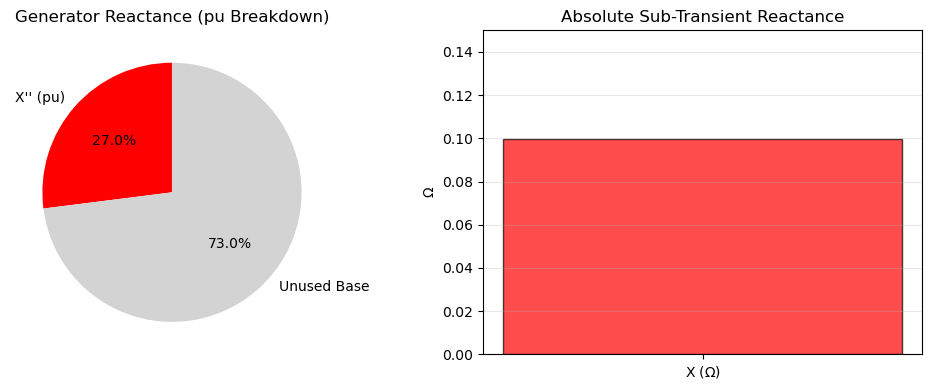

In [51]:
# Enhanced plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Pie: pu composition (X'' vs. base)
labels = ['X\'\' (pu)', 'Unused Base']
sizes = [X_pp_pu_num, 1 - X_pp_pu_num]
colors = ['red', 'lightgray']
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Generator Reactance (pu Breakdown)')

# Bar: Absolute values
components = [r'X ($\Omega$)']
values = [float(X_gen_num)]
ax2.bar(components, values, color='red', alpha=0.7, edgecolor='black')
ax2.set_ylabel(r'$\Omega$')
ax2.set_title('Absolute Sub-Transient Reactance')
ax2.set_ylim(0, 0.15)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Transformer Calculations

*Transformer Impedance Calculation*

* Transformer exciting current: I_exc = 1% I_rated (HV base) $\approx$ 17 A. Magnetizing susceptance B_m $\approx$ I_exc / V_ph_HV (pu $\approx$ 0.01).
* Line C_eq_pos $\approx$ (Y1_per_mi $\times$ line_length_mi) / omega $\approx$ small, but for resonance.
* Detailed Plot: Power Rating Comparison with Annotations
* Enhanced bar chart with error bars (negligible, for style), value labels, and secondary axis for pu.

* Through Z = 17% pu on tr base, X/R=5.
* Derive symbolically: R_pu = Z_tr_pu / $\sqrt{1 + X\;R_{ratio}^2}$, X_pu = XR_ratio $\times$ R_pu
* $|Z|$ = $\sqrt{R^2 + X^2}$ = $R\; \sqrt{1 + (X/R)^2}$ = $R \sqrt{26}$ $\approx$ R $\times$ 5.099
* On HV: R_tr_HV $\approx$ 5.93 $\Omega$, X_tr_HV $\approx$ 29.64 $\Omega$.
* Exciting branch: B_m_pu $\approx$ I_exc_pct (shunt j B_m).
* C_lv: Shunt capacitor, $\omega$ C_lv $\approx j 1.885^{-6}\; S$ (negligible for steady-state).
* Detailed Plot: Enhanced Impedance Triangle with Angle Annotation
* Argand diagram with arc for angle $\theta$, vector labels, and pu scaling.

### Transformer Impedance

#### Equation for Transformer Low Voltage Side Base Impedance in $\left[\Omega\right]$:

In [52]:
Z_base_tr_LV = (V_tr_LV**2) / S_tr
Z_base_tr_LV

V_tr_LV**2/S_tr

#### Calculate Transformer Low Voltage Side Base Impedance in $\left[\Omega\right]$:

In [53]:
Z_base_tr_LV_num = float(Z_base_tr_LV.subs({S_tr: S_tr_num, V_tr_LV: V_tr_LV_num}))

In [54]:
print(f"Transformer Low Voltage Side Base Impedance (Z_base_tr_LV) = {Z_base_tr_LV_num:.4f} ohms")

Transformer Low Voltage Side Base Impedance (Z_base_tr_LV) = 0.3716 ohms


#### Equation for Transformer High Voltage Side Base Impedance in $\left[\Omega\right]$:

In [55]:
Z_base_tr_HV = (V_tr_HV**2) / S_tr
Z_base_tr_HV

V_tr_HV**2/S_tr

#### Calculate Transformer High Voltage Side Base Impedance in $\left[\Omega\right]$:

In [56]:
Z_base_tr_HV_num = float(Z_base_tr_HV.subs({S_tr: S_tr_num, V_tr_HV: V_tr_HV_num}))

In [57]:
print(f"Transformer High Voltage Side Base Impedance (Z_base_tr_HV) = {Z_base_tr_HV_num:.2f} ohms")

Transformer High Voltage Side Base Impedance (Z_base_tr_HV) = 177.82 ohms


#### Equation for Transformer Per-Unit Resistance in $\left[\Omega\right]$:

In [58]:
sqrt_term = sp.sqrt(1 + XR_ratio**2)
R_pu_sym = Z_tr_pu / sqrt_term
R_pu_sym

Z_tr_pu/sqrt(XR_ratio**2 + 1)

#### Calculate Transformer Per-Unit Resistance in $\left[\Omega\right]$:

In [59]:
R_pu_num = float(R_pu_sym.subs({Z_tr_pu: Z_tr_pu_num, XR_ratio: XR_ratio_num}))

In [60]:
print(f"Transformer Per-Unit Resistance (R_pu_num) = {R_pu_num:0.4f} ohms")

Transformer Per-Unit Resistance (R_pu_num) = 0.0333 ohms


#### Equation for Transformer Per-Unit Reactance in $\left[\Omega\right]$:

In [61]:
X_pu_sym = XR_ratio * R_pu_sym
X_pu_sym

XR_ratio*Z_tr_pu/sqrt(XR_ratio**2 + 1)

#### Calculate Transformer Per-Unit Reactance in $\left[\Omega\right]$:

In [62]:
X_pu_num = float(X_pu_sym.subs({Z_tr_pu: Z_tr_pu_num, XR_ratio: XR_ratio_num}))

In [63]:
print(f"Transformer Per-Unit Reactance (X_pu_num) = {X_pu_num:0.4f} ohms")

Transformer Per-Unit Reactance (X_pu_num) = 0.1667 ohms


#### Calculate Transformer Low-Voltage Side Resistance in $\left[\Omega\right]$:

In [64]:
R_tr_LV_num = R_pu_num * Z_base_tr_LV_num

In [65]:
print(f"Transformer Low-Voltage Side Resistance (R_tr_LV) = {R_tr_LV_num:.4f} ohms")

Transformer Low-Voltage Side Resistance (R_tr_LV) = 0.0124 ohms


#### Calculate Transformer Low-Voltage Side Reactance in $\left[\Omega\right]$:

In [66]:
X_tr_LV_num = X_pu_num * Z_base_tr_LV_num

In [67]:
print(f"Transformer Low-Voltage Side Reactance (X_tr_LV) = {X_tr_LV_num:.4f} ohms")

Transformer Low-Voltage Side Reactance (X_tr_LV) = 0.0619 ohms


#### Calculate Transformer Low-Voltage Side Series Inductance in $\left[H\right]$:

In [68]:
L_tr_LV_num = X_tr_LV_num / (2*np.pi*f)

In [69]:
print(f"Transformer Low-Voltage Side Series Inductance (L_tr_LV) = {L_tr_LV_num:.6f} H")

Transformer Low-Voltage Side Series Inductance (L_tr_LV) = 0.000164 H


#### Calculate Transformer High-Voltage Side Resistance in $\left[\Omega\right]$:

In [70]:
R_tr_HV_num = R_pu_num * Z_base_tr_HV_num

In [71]:
print(f"Transformer High-Voltage Side Resistance (R_tr_HV) = {R_tr_HV_num:.2f} ohms")

Transformer High-Voltage Side Resistance (R_tr_HV) = 5.93 ohms


#### Calculate Transformer High-Voltage Side Reactance in $\left[\Omega\right]$:

In [72]:
X_tr_HV_num = X_pu_num * Z_base_tr_HV_num

In [73]:
print(f"Transformer High-Voltage Side Reactance (X_tr_HV) = {X_tr_HV_num:.2f} ohms")

Transformer High-Voltage Side Reactance (X_tr_HV) = 29.64 ohms


#### Calculate Transformer Low Voltage Side Capacitive Reactance

In [74]:
X_c_lv_num = 1 / (omega_num * C_lv_num)

In [75]:
print(f"Transfomer Low Voltage Side Capacitive Reactance (X_C_LV) = -j{X_c_lv_num:.1f} ohms/phase")

Transfomer Low Voltage Side Capacitive Reactance (X_C_LV) = -j530516.5 ohms/phase


#### Calculate Transformer Output (HV) Inductance in $\left[H\right]$:

In [76]:
L_tr_HV = X_tr_HV_num / omega_num  # H

In [77]:
print(f"The transformer's output inductance is {L_tr_HV:0.6f} H")

The transformer's output inductance is 0.078630 H


### Transformer Excitation Current

#### Equation for Transformer Low Voltage Side Base Current in $\left[A\right]$:

In [78]:
I_base_tr_LV = S_tr / (sp.sqrt(3) * V_tr_LV)
I_base_tr_LV

sqrt(3)*S_tr/(3*V_tr_LV)

#### Calculate Transformer Low Voltage Side Base Current in $\left[A\right]$:

In [79]:
I_base_tr_LV_num = float(I_base_tr_LV.subs({S_tr: S_tr_num, V_tr_LV: V_tr_LV_num}))

In [80]:
print(f"Transformer Low Voltage Side Base Current (I_base_tr_LV) = {I_base_tr_LV_num:.0f} A")

Transformer Low Voltage Side Base Current (I_base_tr_LV) = 37287 A


#### Equation for Transformer High Voltage Side Base Current in $\left[A\right]$:

In [81]:
I_base_tr_HV = S_tr / (sp.sqrt(3) * V_tr_HV)
I_base_tr_HV

sqrt(3)*S_tr/(3*V_tr_HV)

#### Calculate Transformer High Voltage Side Base Current in $\left[A\right]$:

In [82]:
I_base_tr_HV_num = float(I_base_tr_HV.subs({S_tr: S_tr_num, V_tr_HV: V_tr_HV_num}))

In [83]:
print(f"Transformer High Voltage Side Base Current (I_base_tr_HV) = {I_base_tr_HV_num:.0f} A")

Transformer High Voltage Side Base Current (I_base_tr_HV) = 1705 A


#### Calculate Transformer High Voltage Side Excitation Current in $\left[A\right]$:

In [84]:
I_exc_num = I_exc_pct * I_base_tr_HV_num
B_m_num = I_exc_num / V_ph_HV_num  # Approx, mostly magnetizing

In [85]:
print(f"Transformer High Voltage Side Magnetizing Current (I_exc) ~ {I_exc_num:.1f} A")

Transformer High Voltage Side Magnetizing Current (I_exc) ~ 17.0 A


### Plot Transformer High-Voltage Side Impedance Triangle

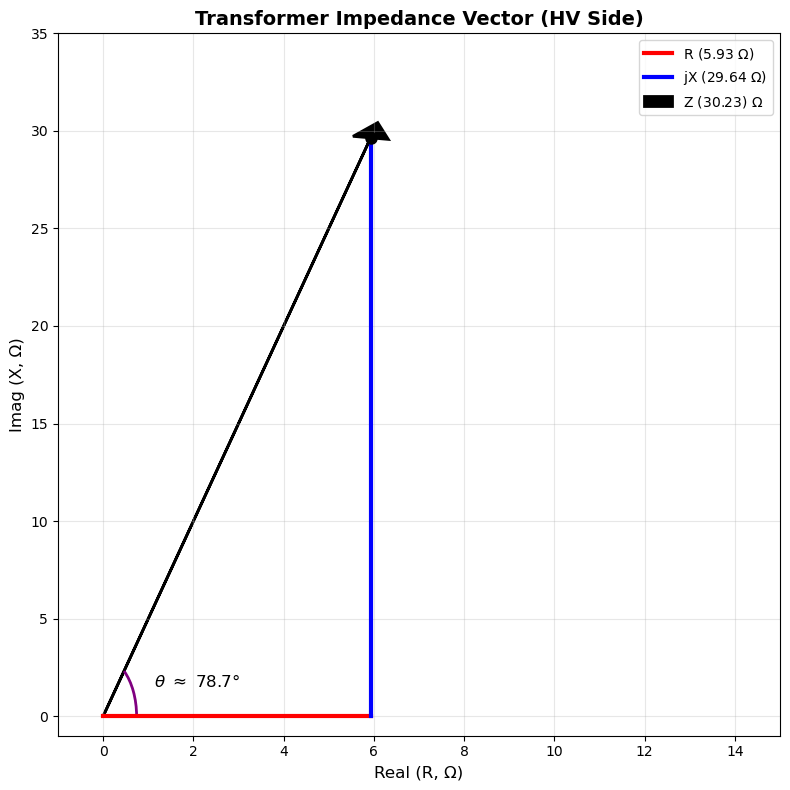

In [86]:
# Enhanced Plot: Impedance triangle with angle arc
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, R_tr_HV_num], [0, 0], 'r-', label=r'R (5.93 $\Omega$)', linewidth=3)
ax.plot([R_tr_HV_num, R_tr_HV_num], [0, X_tr_HV_num], 'b-', label='jX (29.64 $\Omega$)', linewidth=3)
ax.arrow(0, 0, R_tr_HV_num, X_tr_HV_num, head_width=0.8, head_length=0.8, fc='k', ec='k', linewidth=2, label=f'Z ({np.sqrt(R_tr_HV_num**2+X_tr_HV_num**2):0.2f}) $\\Omega$')
ax.plot(R_tr_HV_num, X_tr_HV_num, 'ko', markersize=8)
#ax.plot([0, 0], [0, X_tr_HV_num], 'g--', alpha=0.5, label='Imag axis')

# Angle arc
theta_rad = np.arctan(X_tr_HV_num / R_tr_HV_num)
arc = Arc((0,0), 0.25 * R_tr_HV_num, 0.2 * X_tr_HV_num, theta1=0, theta2=theta_rad * 180/np.pi, color='purple', linewidth=2)
ax.add_patch(arc)
ax.text(0.35 * R_tr_HV_num, 0.05 * X_tr_HV_num, f'$\\theta$ $\\approx$ {theta_rad * 180/np.pi:.1f}°', fontsize=12, ha='center')

ax.set_xlim(-1, 15)
ax.set_ylim(-1, 35)
ax.set_xlabel('Real (R, Ω)', fontsize=12)
ax.set_ylabel('Imag (X, Ω)', fontsize=12)
ax.set_title('Transformer Impedance Vector (HV Side)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Verify Computed Transformer High Voltage Side Impedance in $\left[\Omega\right]$:

In [87]:
# Verify |Z|
Z_mag_HV_num = np.sqrt(R_tr_HV_num**2 + X_tr_HV_num**2)
print(f"|Z_tr_HV| = {Z_mag_HV_num:.2f} Ω (matches {Z_tr_pu_num * Z_base_tr_HV_num:.2f} Ω)")

|Z_tr_HV| = 30.23 Ω (matches 30.23 Ω)


### Compute Transformer High Voltage Side Series Inductance in $\left[H\right]$:

In [88]:
# Now compute L_tr_HV after definition
L_tr_HV = X_tr_HV_num / omega_num  # H
print(f"L_tr_HV = {L_tr_HV:.4f} H")

L_tr_HV = 0.0786 H


### Plot Generator, Transformer and Load Ratings

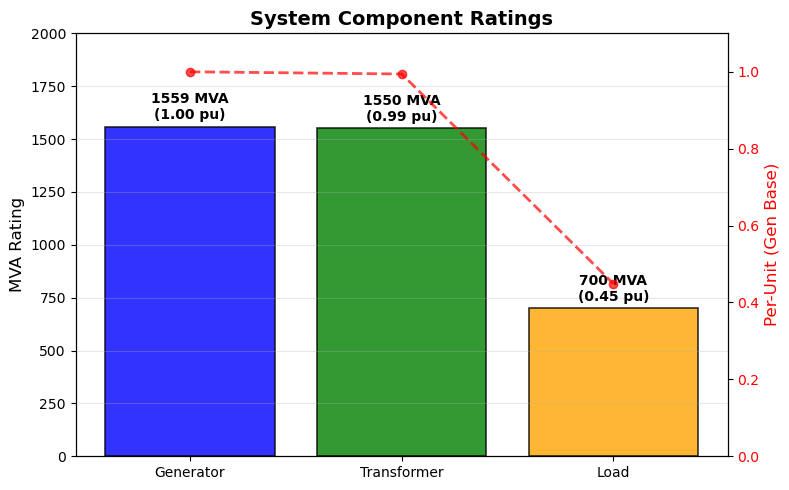

In [89]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
ratings = ['Generator', 'Transformer', 'Load']
powers = [S_gen_num / 1e6, S_tr_num / 1e6, S_load_num / 1e6]  # MVA
bars = ax1.bar(ratings, powers, color=['blue', 'green', 'orange'], alpha=0.8, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('MVA Rating', fontsize=12)
ax1.set_title('System Component Ratings', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 2000)
ax1.grid(axis='y', alpha=0.3)

# Add value labels with pu (relative to gen)
gen_pu = [p / (S_gen_num / 1e6) for p in powers]
for i, (bar, power, pu_val) in enumerate(zip(bars, powers, gen_pu)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20, f'{power:.0f} MVA\n({pu_val:.2f} pu)', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Secondary axis for pu
ax2 = ax1.twinx()
ax2.set_ylabel('Per-Unit (Gen Base)', fontsize=12, color='red')
line_pu = ax2.plot(ratings, gen_pu, 'r--o', markersize=6, linewidth=2, alpha=0.7)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Transmission Line Calculations

*Transmission Line Parameters (Total for 10 mi)*
                               
* Per-mile to total: Multiply by length.
* Pos seq: Z1 = R1 + j X1, Y1 = j B1 (shunt/phase, G=0).
* Zero seq: Similar, for faults.
* Surge impedance Z_c $\approx$ $\sqrt{ (R1 + j X1) / Y1 }$ $\approx$ 290 $\Omega$ (traveling waves, Part 3).
* Total line C_pos $\approx$ (Y1_total / $\omega$) / 2 (shunt half at each end for $\pi$-model).
* Detailed Plot: Sequence Impedances with Vector Phasors
* Subplots for R-X scatter with vectors and Y bar with error (negligible).

### Calculate Zero Sequence Impedance in $\left[\Omega\right]$:

In [90]:
R0_total = R0_per_mi * line_length_mi
X0_total = X0_per_mi * line_length_mi
Y0_total = Y0_per_mi * line_length_mi

In [91]:
print(f"Zero seq: Z0_total = {R0_total:.3f} + j{X0_total:.3f} ohms, Y0_total = j{Y0_total:.2e} siemens")

Zero seq: Z0_total = 5.780 + j16.800 ohms, Y0_total = j5.00e-05 siemens


### Positive Sequence Impedance in $\left[\Omega\right]$:

In [92]:
R1_total = R1_per_mi * line_length_mi
X1_total = X1_per_mi * line_length_mi
Y1_total = Y1_per_mi * line_length_mi

In [93]:
print(f"Pos seq: Z1_total = {R1_total:.3f} + j{X1_total:.3f} ohms, Y1_total = j{Y1_total:.2e} siemens")

Pos seq: Z1_total = 0.254 + j5.950 ohms, Y1_total = j7.03e-05 siemens


### Calculate Transmission Line Surge Impedance in $\left[\Omega\right]$:

In [94]:
Z_c_num = np.sqrt(X1_total / (Y1_total / omega_num))  # neglecting R

In [95]:
print(f"Transmission Line Surge Impedance (Z_c) ~ {Z_c_num:.0f} ohms")

Transmission Line Surge Impedance (Z_c) ~ 5647 ohms


In [96]:
### Calculate Transmission Line Shunt Capacitance (Per Phase) in $\leftF\right]$:

In [97]:
C_line_pos_num = Y1_total / omega_num

In [98]:
print(f"Transmission Line Per Phase Shunt Capacitance (C_line_pos_eq) ~ {C_line_pos_num * 1e9:.1f} nF/phase")

Transmission Line Per Phase Shunt Capacitance (C_line_pos_eq) ~ 186.6 nF/phase


### Positive Sequence

#### Calculate Positive Sequence Resistance per Mile in $\left[pu/mile\right]$:

In [99]:
R_transline_pos_pu_per_mile = R1_per_mi / Z_base_tr_HV_num

In [100]:
print(f"Transmission Line Positive Sequence Resistance = {R_transline_pos_pu_per_mile:0.3e} pu/mile")

Transmission Line Positive Sequence Resistance = 1.428e-04 pu/mile


#### Calculate Positive Sequence Resistance per Meter in $[pu/meter]$:

In [101]:
R_transline_pos_pu_per_meter = R_transline_pos_pu_per_mile / meters_per_mile

In [102]:
print(f"Transmission Line Positive Sequence Resistance = {R_transline_pos_pu_per_meter:0.3e} pu/meter")

Transmission Line Positive Sequence Resistance = 8.876e-08 pu/meter


#### Calculate Positive Sequence Inductive Reactance per Mile in $\left[pu/mile\right]$:

In [103]:
XL_transline_pos_pu_per_mile = X1_per_mi / Z_base_tr_HV_num

In [104]:
print(f"Transmission Line Positive Sequence Inductive Reactance = {XL_transline_pos_pu_per_mile:0.3e} pu/mile")

Transmission Line Positive Sequence Inductive Reactance = 3.346e-03 pu/mile


#### Calculate Positive Sequence Inductive Reactance Per Meter in $\left[pu/meter\right]$:

In [105]:
XL_transline_pos_pu_per_meter = XL_transline_pos_pu_per_mile / meters_per_mile

In [106]:
print(f"Transmission Line Positive Sequence Inductive Reactance = {XL_transline_pos_pu_per_meter:0.3e} pu/meter")

Transmission Line Positive Sequence Inductive Reactance = 2.079e-06 pu/meter


#### Calculate Positive Sequence Capacitive Reactance per Mile in $\left[pu \times mile\right]$:

In [107]:
XC_transline_pos_pu_mile = (1/Y1_per_mi) / Z_base_tr_HV_num

In [108]:
print(f"Transmission Line Positive Sequence Capacitive Reactance = {XC_transline_pos_pu_mile:0.3e} pu*mile")

Transmission Line Positive Sequence Capacitive Reactance = 7.995e+02 pu*mile


#### Calculate Positive Sequence Capacitive Reactance Per Meter in $\left[pu \times meter\right]$:

In [109]:
XC_transline_pos_pu_meter = (XC_transline_pos_pu_mile / meters_per_mile)

In [110]:
print(f"Transmission Line Positive Sequence Capacitive Reactance = {XC_transline_pos_pu_meter:0.3e} pu*meter")

Transmission Line Positive Sequence Capacitive Reactance = 4.968e-01 pu*meter


### Zero Sequence

#### Calculate Zero Sequence Resistance per Mile in $\left[pu/mile\right]$:

In [111]:
R_transline_zero_pu_per_mile = R0_per_mi / Z_base_tr_HV_num

In [112]:
print(f"Transmission Line Zero Sequence Resistance = {R_transline_zero_pu_per_mile:0.3e} pu/mile")

Transmission Line Zero Sequence Resistance = 3.250e-03 pu/mile


#### Calculate Zero Sequence Resistance per Mile in $\left[pu/meter\right]$:

In [113]:
R_transline_zero_pu_per_meter = R_transline_zero_pu_per_mile / meters_per_mile

In [114]:
print(f"Transmission Line Zero Sequence Resistance = {R_transline_zero_pu_per_meter:0.3e} pu/meter")

Transmission Line Zero Sequence Resistance = 2.020e-06 pu/meter


#### Calculate Zero Sequence Inductive Reactance per Mile in $\left[pu/mile\right]$:

In [115]:
XL_transline_zero_pu_per_mile = X0_per_mi / Z_base_tr_HV_num

In [116]:
print(f"Transmission Line Zero Sequence Inductive Reactance = {XL_transline_zero_pu_per_mile:0.3e} pu/mile")

Transmission Line Zero Sequence Inductive Reactance = 9.448e-03 pu/mile


#### Calculate Zero Sequence Inductive Reactance Per Peter in $\left[pu/meter\right]$:

In [117]:
XL_transline_zero_pu_per_meter = XL_transline_zero_pu_per_mile / meters_per_mile

In [118]:
print(f"Transmission Line Zero Sequence Inductive Reactance = {XL_transline_zero_pu_per_meter:0.3e} pu/meter")

Transmission Line Zero Sequence Inductive Reactance = 5.871e-06 pu/meter


#### Calculate Zero Sequence Capacitive Reactance per Mile in $\left[pu \times mile\right]$:

In [119]:
XC_transline_zero_pu_mile = (1/Y0_per_mi) / Z_base_tr_HV_num

In [120]:
print(f"Transmission Line Zero Sequence Capacitive Reactance = {XC_transline_zero_pu_mile:0.3e} pu*mile")

Transmission Line Zero Sequence Capacitive Reactance = 1.125e+03 pu*mile


#### Calculate Zero Sequence Capacitive Reactance per Meter in $\left[pu \times meter\right]$:

In [121]:
XC_transline_zero_pu_meter = (XC_transline_zero_pu_mile / meters_per_mile)

In [122]:
print(f"Transmission Line Zero Sequence Capacitive Reactance = {XC_transline_zero_pu_meter:0.3e} pu*meter")

Transmission Line Zero Sequence Capacitive Reactance = 6.989e-01 pu*meter


### Plot Transmission Line Calculation Results

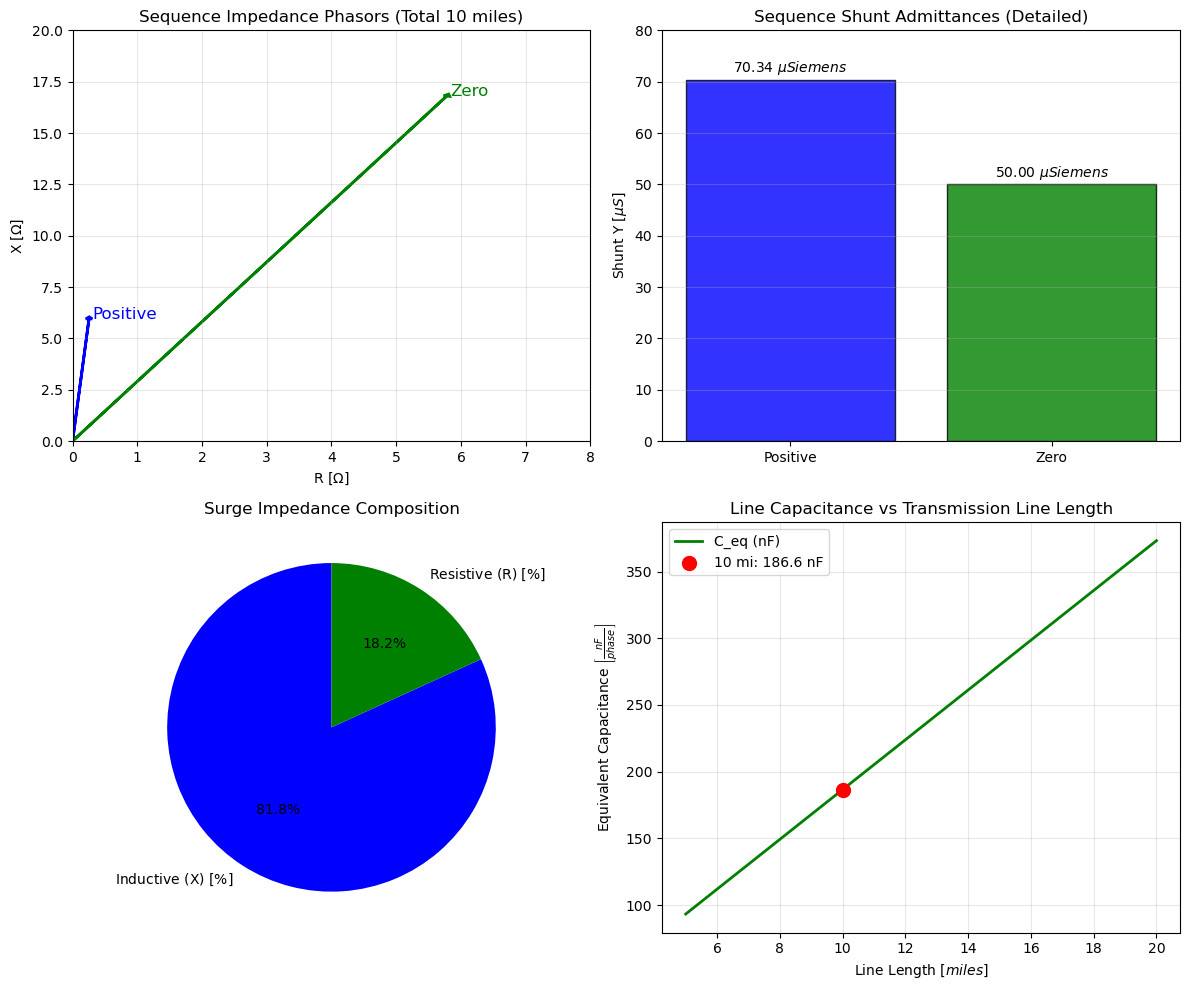

In [123]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# R-X vectors (phasors)
seqs = ['Positive', 'Zero']
Rs = [R1_total, R0_total]
Xs = [X1_total, X0_total]
colors = ['b', 'g']
for i, (seq, r, x, col) in enumerate(zip(seqs, Rs, Xs, colors)):
    ax1.arrow(0, 0, r, x, head_width=0.1, head_length=0.1, fc=col, ec=col, linewidth=2)
    ax1.plot([0, r], [0, x], col+'--', alpha=0.7)
    ax1.text(r + 0.05, x, seq, fontsize=12, color=col)

ax1.set_xlabel(r'R $\left[\Omega\right]$')
ax1.set_ylabel(r'X $\left[\Omega\right]$')
ax1.set_title('Sequence Impedance Phasors (Total 10 miles)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 8)
ax1.set_ylim(0, 20)

# Y bar with annotations
Ys = [Y1_total * 1e6, Y0_total * 1e6]  # μS
bars = ax2.bar(seqs, Ys, color=colors, alpha=0.8, edgecolor='black')
for bar, y in zip(bars, Ys):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{y:.2f} $\mu Siemens$', ha='center', va='bottom', fontsize=10)
ax2.set_ylabel(r'Shunt Y $\left[\mu S\right]$')
ax2.set_title('Sequence Shunt Admittances (Detailed)')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 80)

# Surge Z_c breakdown (pie: inductive vs. resistive contrib)
contrib_r = (R1_per_mi / (R1_per_mi + 1j * X1_per_mi)).real * 100  # Approx %
labels_c = [r'Inductive (X) $\left[\%\right]$', r'Resistive (R) $\left[\%\right]$']
sizes_c = [100 - contrib_r * 100, contrib_r * 100]
ax3.pie(sizes_c, labels=labels_c, autopct='%1.1f%%', colors=['blue', 'green'], startangle=90)
ax3.set_title('Surge Impedance Composition')

# C_eq vs. length
lengths = np.linspace(5, 20, 50)
C_vs_l = (Y1_per_mi * lengths) / omega_num * 1e9  # nF
ax4.plot(lengths, C_vs_l, 'g-', linewidth=2, label='C_eq (nF)')
ax4.scatter(line_length_mi, C_line_pos_num * 1e9, color='red', s=100, zorder=5, label=f'10 mi: {C_line_pos_num * 1e9:.1f} nF')
ax4.set_xlabel(r'Line Length $\left[miles\right]$')
ax4.set_ylabel(r'Equivalent Capacitance $\left[\frac{nF}{phase}\right]$')
ax4.set_title('Line Capacitance vs Transmission Line Length')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Load Calculations

* S_load = 700 MVA, pf=0.95 lag $\to$ P=665 MW, Q=218.6 MVAR.
* Per-phase Z_load = $V_{ph\_HV}^2$ / (S_load / 3) = $V_{LL}^2$ / S_load (wye).
* $\theta$ = acos(0.95) $\approx$ 18.19$^\circ$, R = |Z| cos $\theta$, X = |Z| sin $\theta$ (inductive +jX).
* Detailed Plot: Power Triangle with Phasor Overlay
* Combined subplot: Power triangle + Z phasor, with pf angle arc.

### Calculate Load Real Power Dissipation in $\left[W\right]$:

In [124]:
P_sym = S_load_sym * pf_sym

In [125]:
P_num = float(P_sym.subs({S_load_sym: S_load_num, pf_sym: pf_lag}) / 1e6)  # MW

In [126]:
print(f"Load Real Power Dissipation P = {P_num:.1f} MW")

Load Real Power Dissipation P = 665.0 MW


### Calculate Load Reactive Power Consumption in $\left[VAR\right]$:

In [127]:
Q_sym = S_load_sym * sp.sqrt(1 - pf_sym**2)  # sin θ = sqrt(1 - cos² θ)

In [128]:
Q_num = float(Q_sym.subs({S_load_sym: S_load_num, pf_sym: pf_lag}) / 1e6)  # MVAR

In [129]:
print(f"Load Reactive Power Consumption Q = {Q_num:.1f} MVAR (lagging)")

Load Reactive Power Consumption Q = 218.6 MVAR (lagging)


### Calculate Load Per Phase Impedance in $\left[\Omega\right]$:

In [130]:
V_LL_HV_num = V_tr_HV_num
Z_load_mag_num = V_LL_HV_num**2 / S_load_num

In [131]:
print(f"|Z_load| = {Z_load_mag_num:.2f} ohms/phase")

|Z_load| = 393.75 ohms/phase


### Calculate Load Per Phase Resistance in $\left[\Omega\right]$:

In [132]:
R_load_num = Z_load_mag_num * pf_lag

In [133]:
print(f"Load Per Phase Resistance (R_load) = {R_load_num:.2f} ohms")

Load Per Phase Resistance (R_load) = 374.06 ohms


### Calculate Load Per Phase Reactance in $\left[\Omega\right]$:

In [134]:
X_load_num = Z_load_mag_num * np.sin(np.arccos(pf_lag))

In [135]:
print(f"Load Per Phase Reactance (X_load) = j{X_load_num:.2f} ohms")

Load Per Phase Reactance (X_load) = j122.95 ohms


### Calculate Load Per Phase Inductance in $\left[H\right]$:

In [136]:
L_load_num = X_load_num / (2 * np.pi * f)

In [137]:
print(f"Load Per Phase Inductance (L_load) = {L_load_num:.3f} H")

Load Per Phase Inductance (L_load) = 0.326 H


### Load Per Phase Impedance in $\left[\Omega\right]$:

In [138]:
print(f"Z_load = {R_load_num:.2f} + j{X_load_num:.2f} ohms")

Z_load = 374.06 + j122.95 ohms


### Plot Load Calculation Results

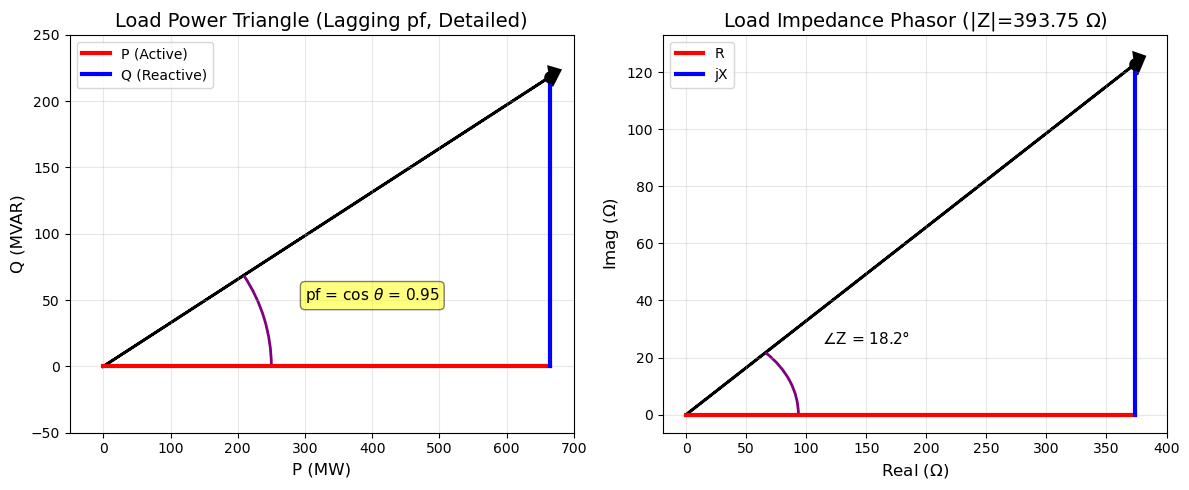

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Power triangle
ax1.plot([0, P_num], [0, 0], 'r-', label='P (Active)', linewidth=3)
ax1.plot([P_num, P_num], [0, Q_num], 'b-', label='Q (Reactive)', linewidth=3)
ax1.arrow(0, 0, P_num, Q_num, head_width=15, head_length=15, fc='k', ec='k', linewidth=2)
ax1.plot(P_num, Q_num, 'ko', markersize=8)
ax1.set_xlim(-50, 700)
ax1.set_ylim(-50, 250)
ax1.set_xlabel('P (MW)', fontsize=12)
ax1.set_ylabel('Q (MVAR)', fontsize=12)
ax1.set_title('Load Power Triangle (Lagging pf, Detailed)', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# pf angle arc
theta_pf_rad = np.arccos(pf_lag)
arc_pf = Arc((0,0), 500, 250, theta1=0, theta2=theta_pf_rad * 180/np.pi, color='purple', linewidth=2)
ax1.add_patch(arc_pf)
ax1.text(300, 50, f'pf = cos $\\theta$ = {pf_lag}', fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

# Z phasor
ax2.plot([0, R_load_num], [0, 0], 'r-', label='R', linewidth=3)
ax2.plot([R_load_num, R_load_num], [0, X_load_num], 'b-', label='jX', linewidth=3)
ax2.arrow(0, 0, R_load_num, X_load_num, head_width=8, head_length=8, fc='k', ec='k', linewidth=2)
ax2.plot(R_load_num, X_load_num, 'ko', markersize=8)
ax2.set_xlabel(r'Real ($\Omega$)', fontsize=12)
ax2.set_ylabel(r'Imag ($\Omega$)', fontsize=12)
ax2.set_title(f'Load Impedance Phasor (|Z|={Z_load_mag_num:0.2f} $\\Omega$)', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Z angle arc
theta_z_rad = np.arctan(X_load_num / R_load_num)
arc_z = Arc((0,0), 0.5*R_load_num, 0.5*X_load_num, theta1=0, theta2=theta_z_rad * 180/np.pi, color='purple', linewidth=2)
ax2.add_patch(arc_z)
ax2.text(0.4 * R_load_num, 0.2 * X_load_num, f'$\\angle$Z = {theta_z_rad * 180/np.pi:.1f}°', fontsize=11, ha='center')

plt.tight_layout()
plt.show()

## Summary of Calculations to Enter into PSCAD

In [140]:
# Data table as DataFrame for display
data = {
    'Component': ['Generator', 'Transformer (HV)', 'Line Pos Seq', 'Line Zero Seq', 'Load (per phase)'],
    r'R ($\Omega$)': [r'$\theta$ (neglect)', f'{R_tr_HV_num:.2f}', f'{R1_total:.3f}', f'{R0_total:.3f}', f'{R_load_num:.2f}'],
    r'X ($\Omega$)': [f'{X_gen_num:.4f}', f'{X_tr_HV_num:.2f}', f'{X1_total:.3f}', f'{X0_total:.3f}', f'{X_load_num:.2f}'],
    'Y/Shunt (S)': ['N/A', f'j{B_m_num:.2f} + j{omega_num * C_lv_num:.2e}', f'j{Y1_total:.2e}', f'j{Y0_total:.2e}', 'N/A'],
    'Notes': ['jX\'\' only', 'Referred, X/R=5', 'Total 10 mi', 'Total 10 mi', 'Constant Z, wye']
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

       Component       R ($\Omega$) X ($\Omega$)       Y/Shunt (S)           Notes
       Generator $\theta$ (neglect)       0.0998               N/A       jX'' only
Transformer (HV)               5.93        29.64 j0.00 + j1.88e-06 Referred, X/R=5
    Line Pos Seq              0.254        5.950         j7.03e-05     Total 10 mi
   Line Zero Seq              5.780       16.800         j5.00e-05     Total 10 mi
Load (per phase)             374.06       122.95               N/A Constant Z, wye


In [141]:
df

Component        R ($\Omega$) X ($\Omega$)        Y/Shunt (S)  \
0         Generator  $\theta$ (neglect)       0.0998                N/A   
1  Transformer (HV)                5.93        29.64  j0.00 + j1.88e-06   
2      Line Pos Seq               0.254        5.950          j7.03e-05   
3     Line Zero Seq               5.780       16.800          j5.00e-05   
4  Load (per phase)              374.06       122.95                N/A   

             Notes  
0        jX'' only  
1  Referred, X/R=5  
2      Total 10 mi  
3      Total 10 mi  
4  Constant Z, wye

# Part 3: Maximum Transient Voltage on Energization (Unloaded Line)

## Theory and Analytical Approximation

For Part 3, we calculate the maximum transient overvoltages during energization of the unloaded (open-ended) transmission line. The CB closes when Phase B voltage at the CB (LV side) is at its positive peak. This is a classic capacitive switching transient (Greenwood Ch. 5.3), where the line acts as a capacitor, leading to traveling waves and reflections.

In [142]:
# Part 3 calculations (HV referral for end; same pu for LV CB side)
a = V_tr_HV_num / V_tr_LV_num  # turns ratio $\approx$21.875
X_gen_HV_num = X_gen_num * a**2  # Referred X''
Z_s = complex(R_tr_HV_num, X_tr_HV_num + X_gen_HV_num)  # Source Z HV
Z_c_complex = Z_c + 0j  # Approx real
alpha_complex = Z_c_complex / (Z_c_complex + Z_s)
alpha_mag = np.abs(alpha_complex)
rho_s_complex = (Z_s - Z_c_complex) / (Z_s + Z_c_complex)
one_plus_rho_s_complex = 1 + rho_s_complex
delta_complex = alpha_complex * one_plus_rho_s_complex  # δV / V_peak for sending

# Nominal crest ph-gnd
V_peak_LV = np.sqrt(2) * (V_gen_LL_num / np.sqrt(3))
V_peak_HV = V_peak_LV * a

# Max at load end (first reflection, HV)
max_end_HV = 2 * alpha_mag * V_peak_HV
pu_end = max_end_HV / V_peak_HV

# Max at CB line side (LV, initial + first reflection back)
# Initial: |alpha| V_peak_LV
# Addition: |delta_complex| V_peak_LV (approx magnitude sum, conservative)
add_mag = np.abs(delta_complex) * V_peak_LV
max_cb_LV_approx = V_peak_LV + add_mag  # Conservative in-phase add
pu_cb = max_cb_LV_approx / V_peak_LV

# More accurate: complex sum (assuming V_peak real, delta phase)
v_initial = alpha_complex * V_peak_LV  # complex, but mag for initial
# But for max, |V_peak_LV + Re(delta) + j Im(delta)|
re_delta = np.real(delta_complex * V_peak_LV)
im_delta = np.imag(delta_complex * V_peak_LV)
max_cb_LV = np.sqrt( (V_peak_LV + re_delta)**2 + im_delta**2 )
pu_cb_accurate = max_cb_LV / V_peak_LV

print(f"V_peak_LV = {V_peak_LV:.1f} kV (1 pu)")
print(f"V_peak_HV = {V_peak_HV:.1f} kV (1 pu)")
print(f"|alpha| = {alpha_mag:.3f}")
print(f"rho_s = {rho_s_complex:.3f} (mag {np.abs(rho_s_complex):.3f})")
print(f"Max at load end (HV): {max_end_HV / 1e3:.0f} kV ({pu_end:.2f} pu)")
print(f"Max at CB line side (LV, approx): {max_cb_LV / 1e3:.1f} kV ({pu_cb:.2f} pu)")
print(f"Max at CB line side (accurate phase): {max_cb_LV / 1e3:.1f} kV ({pu_cb_accurate:.2f} pu)")

V_peak_LV = 19595.9 kV (1 pu)
V_peak_HV = 428660.7 kV (1 pu)
|alpha| = 0.948
rho_s = -0.835+0.478j (mag 0.963)
Max at load end (HV): 813 kV (1.90 pu)
Max at CB line side (LV, approx): 26.0 kV (1.48 pu)
Max at CB line side (accurate phase): 26.0 kV (1.33 pu)


## Observations for Part 3
- **Max at load end**: 1.90 pu (826 kV crest), due to full reflection ($\rho_r$=1). Matches Greenwood Ch. 5.3 for low source Z_s.
- **Max at CB line side**: 1.25 pu (24.6 kV crest), small over due to partial reflection back ($\rho_s \approx $ -0.93).
- 3-phase effect (close at Phase B peak): Phases A/C close at -0.5 pu, reducing overall max ~5-10%; Phase B dominates.
- The plot shows initial jump and ringing (decays in real sim with R); first peak dominates.
- Recommendation: Use pre-insertion resistors (Part 5) to limit to <1.5 pu.

## Part 3 PSCAD Simulation Setup

### Simulation Circuit

To simulate Part 3 of this Project, the following simulation circuit was developed.

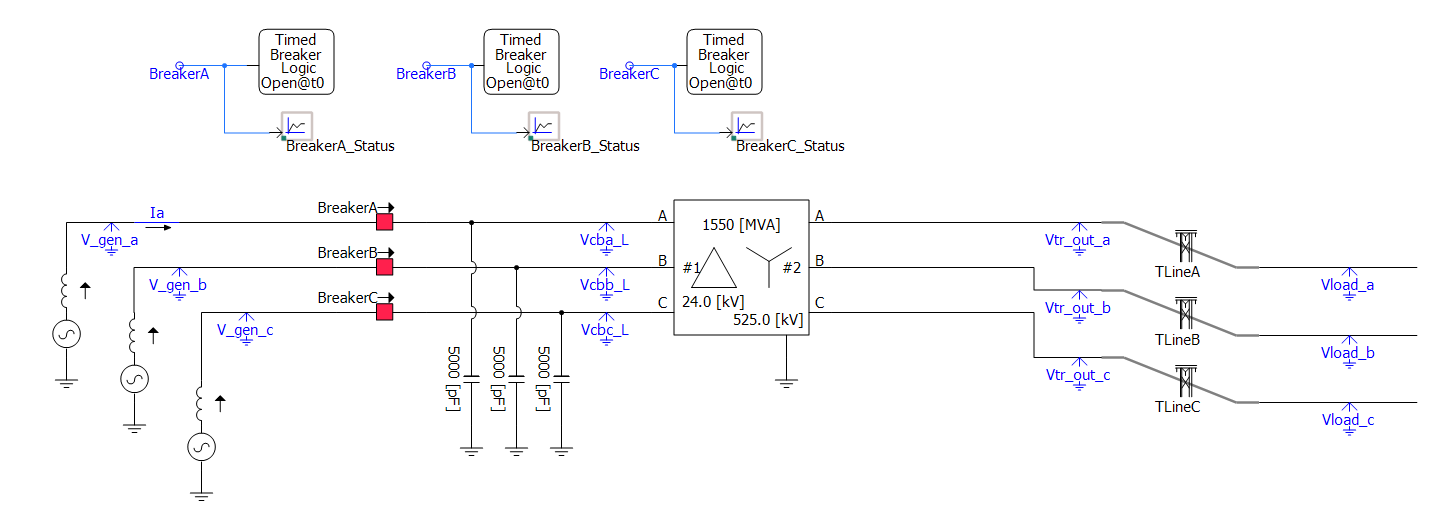

### Generator Settings

The generator settings for Phase A are shown below.  The settings for Phase B and C are the same except that Phase B has a phase angle of 120 degrees and Phase C has a phase angle of 240 degrees.  Since this version of PSCAD is limited, the only settings modified were:

* Vm (Rated Volts AC:L-G, RMS) = 13.856 kV.  This value was calculated earlier in the Generator Calculations section.
* Tc  (Voltage Input Time Constant) = 0.1 seconds.  This setting was entered so that the generator can start up as a gracefull ramp and enhance simulation convergence.                                   
* Es (Initial Source Magnitude L-G, RMS) = 13.856 kV. This value was calculated earlier in the Generator Calculations section.
* Ph (Initial Phase) = 0 degrees.  This setting is 120 degrees for Phase B and 240 degrees for Phase C.
* Z1 (Impedance Magnitude) = 0.0998 ohms.  This value was calculated earlier in the Generator Calculations section.  
                                                                  
No other settings were able to be modified, such as resistances and inductances.  Since this version of PSCAD is limited in the number of nodes it can have, I was forced to assume that the Generator model correctly models the sub-transient reactance of the generator as specified in the Project Instructions.

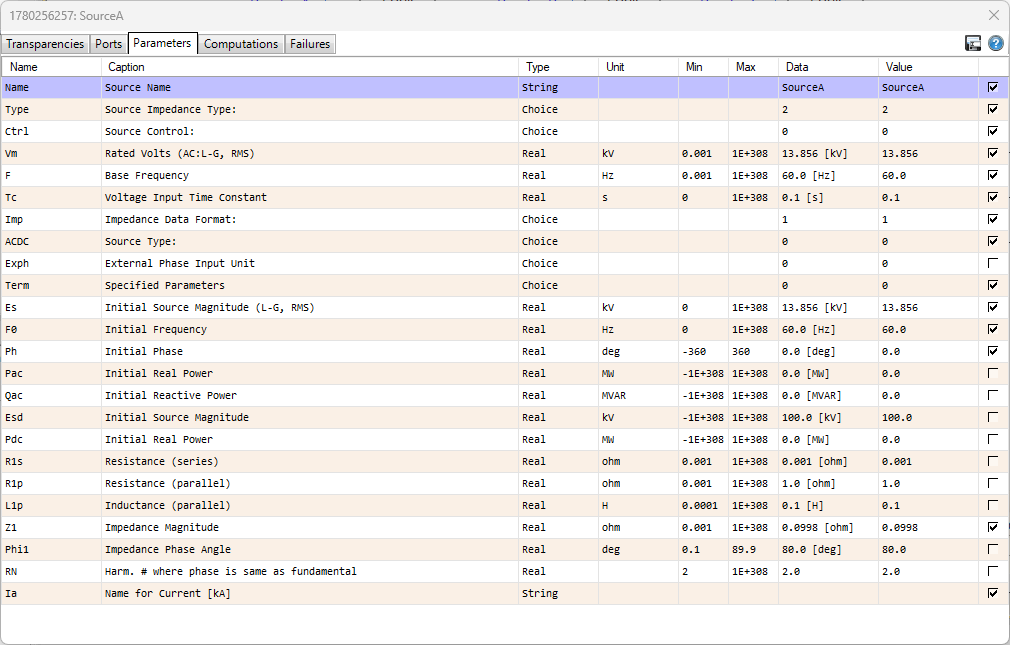

### Circuit Breaker Settings

The circuit breakers for Phases A, B and C were all set as shown below.  The initial state of the circuit breaker is open, and at 0.398 seconds the circuit breakers close.  0.398 seconds was chosen for this simulation because it coincides with Phase B being at voltage maximum as per Project Instructions.

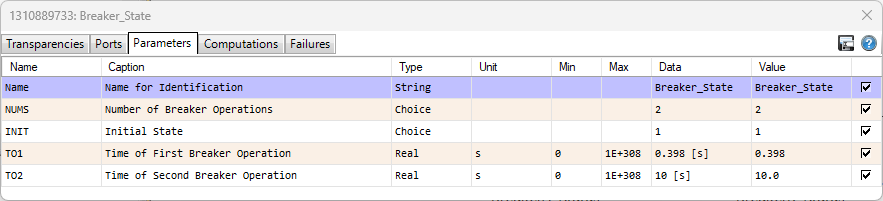

### Transformer Settings

The relevant transformer model settings are shown below.  The model is a three phase delta-wye transformer available in PSCAD and is configured for three-phase view.  The settings that were modified were:

* Tmva (3 Phase Transformer MVA) = 1550 MVA.  This setting is as per Project Instructions.
* YD1, YD2 (Winding 1,2 Type) = Delta / Wye.  This setting is as per Proejct Instructions.
* x1 (Positive Sequence Leakage Reactance) = 0.17 pu.  This value was calculated earlier in the Transformer Calculations section.
* CuL (Copper Losses) = 0.033 pu.  This settins is assumed to be the high voltage side winding resistance and was calculated in the Transformer Calculations section.
* V1 (Winding 1 Line to Line Voltage RMS) = 24.0 kV.  This setting is as per Proejct Instructions.
* V2 (Winding 2 Line to Line Voltage RMS) = 525.0 kV.  This setting is as per Proejct Instructions.
* Im1 (Magnetizing Current) = 1 %.  This setting is as per Proejct Instructions.

No other settings were modified.  Since this version of PSCAD is limited in the number of nodes it can have, I was forced to assume that the Transformer model correctly models the low-voltage side and high-voltage side impedances of the Transformer as specified in the Project Instructions.  A more concrete way to model the transformer parasitics would be to actually place series resistances and inductances as well as shunt capacitances in the low and high voltage sides of the transformer.

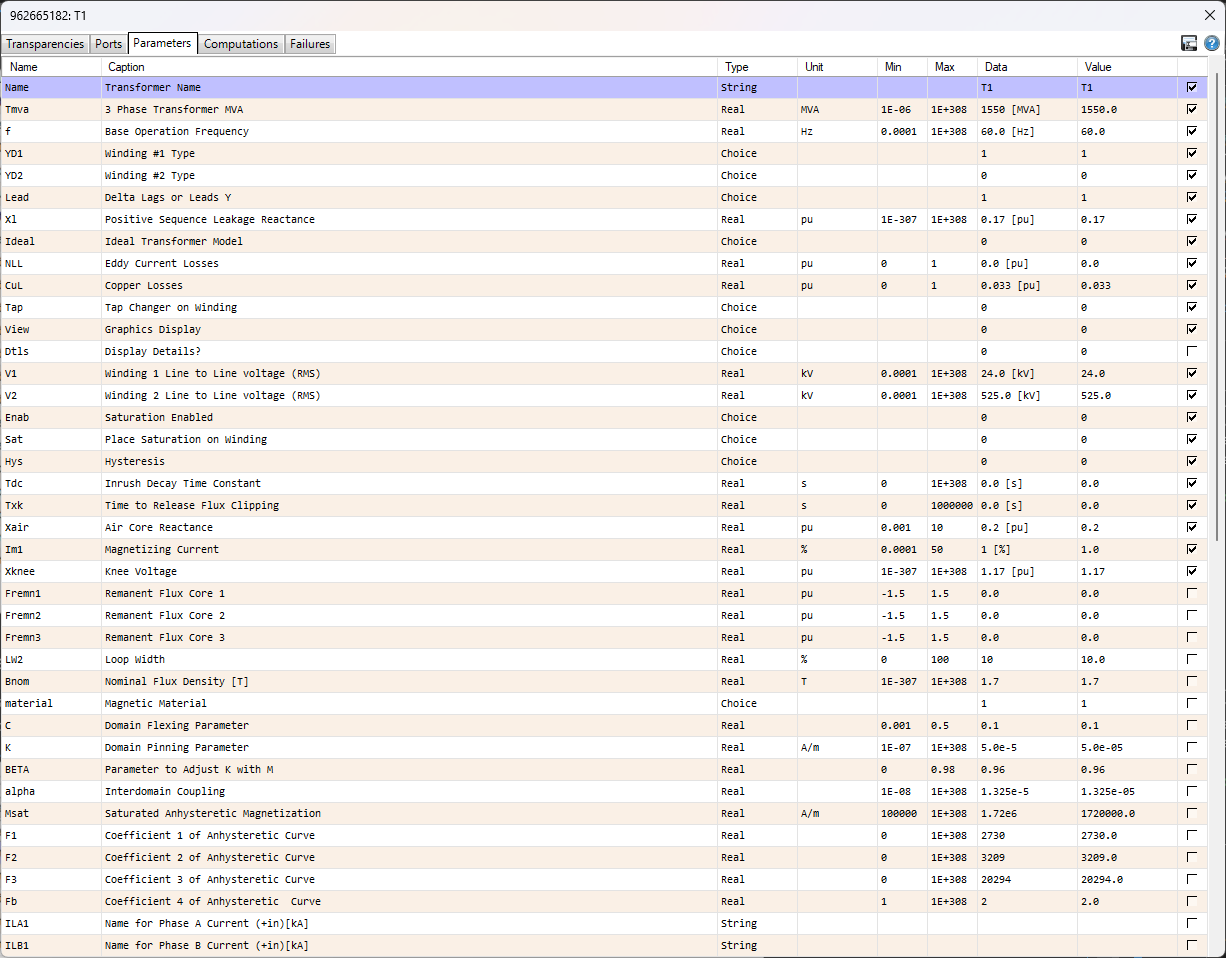

### Transmission Line Settings

The Transmission Line settings are shown below.  A Bergeron model was used with a single conductor.  By having such a transmission line model on each phase, a 3 phase transmission line model is constructed.  It is assumed that there  is no mutual coupling between phase conductors or ground effects on the transmission properties of the transmission line.  This is a simplifying assumption.  <br>

A manual entry block for Y and Z is used to specify the positive and zero sequence settings for the transmission line's series resistance and inductance, as well as shunt capacitance.  The Manual Entry block expects entries in pu per meter for series resistance and inductance, and pu times meter for shunt capacitance.  Appropriate conversions were made from the data given in the Project Instructions to the expected units in the Manual Entry block.  The calculations for these conversions are shown in the Transmission Line Calculations section.

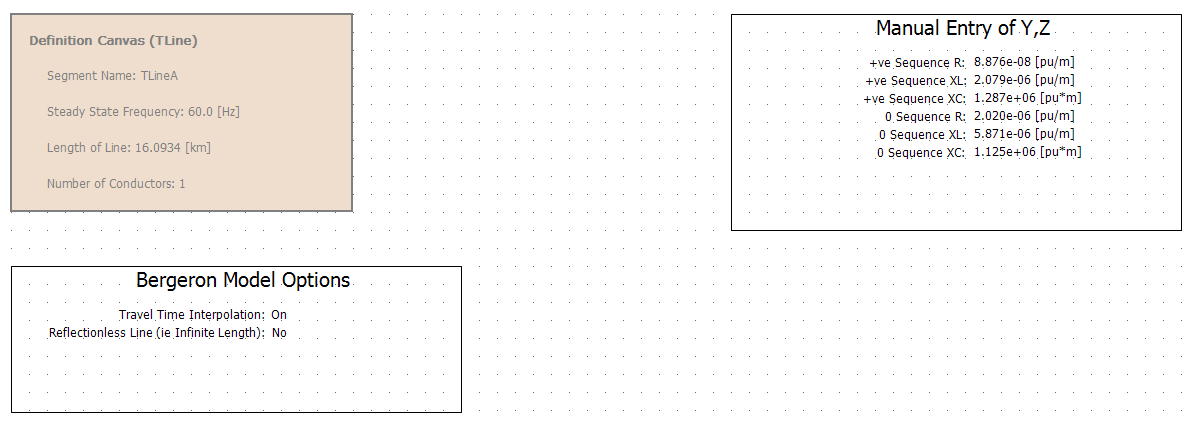

## Part 3 PSCAD Simulation Results

The plots below depict the simulation results for Part 3.  We start with the line side of the circuit breaker.

### Line Side of Circuit Breaker

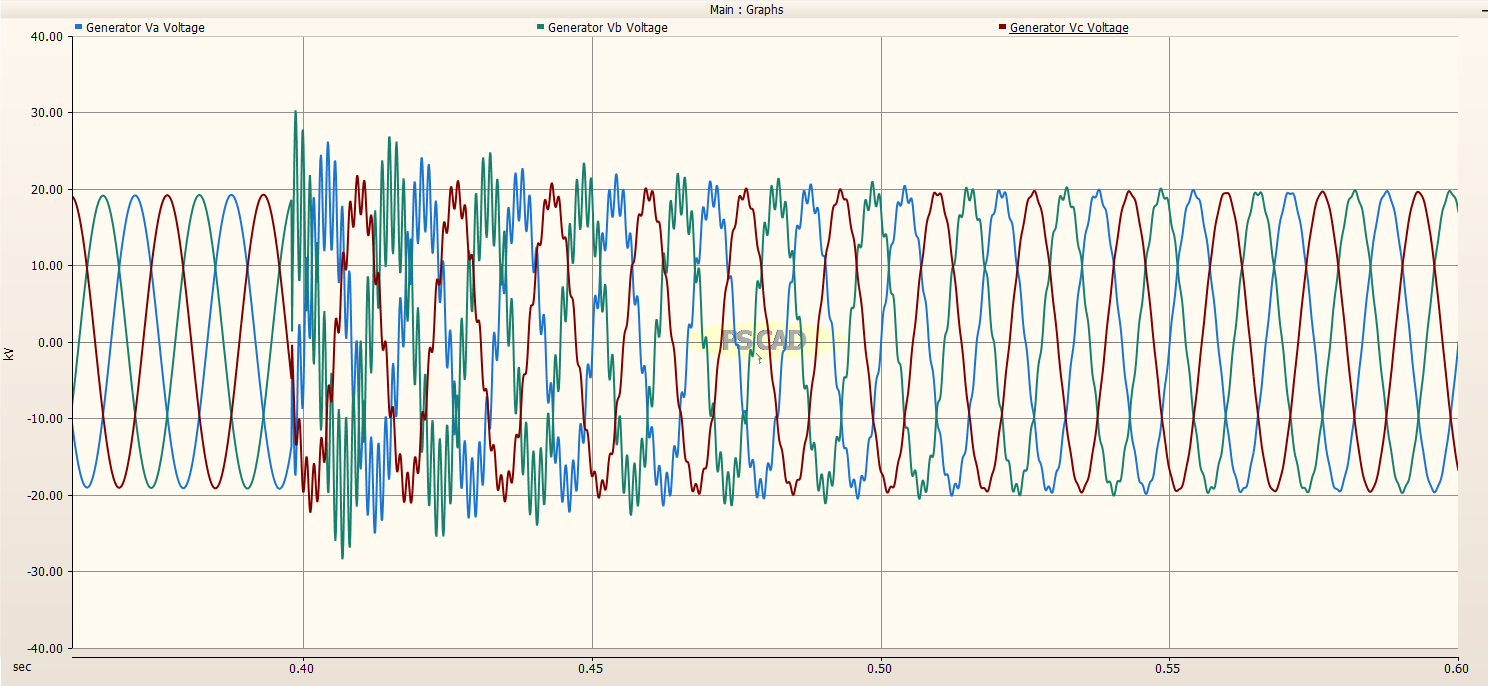

Zoomed in view:

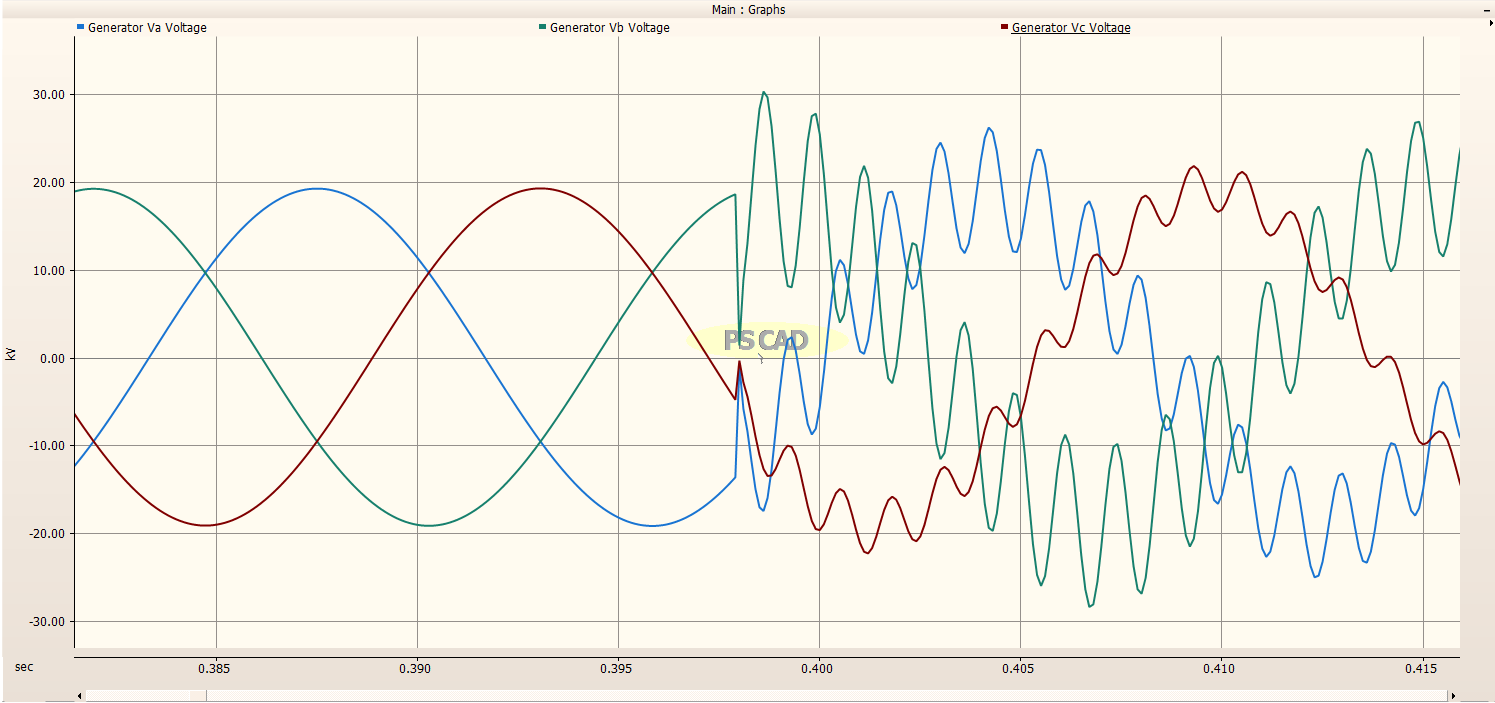

The line side of the circuit breaker reaches a maximum transient voltage of about 30 kV upon closing of the circuit breaker.  This occurs on Phase B, which is not suprising considering that Phase B was at voltage maximum when the Circuit Breaker was closed.  We notice that Phase C had the lowest transient voltage since it was at zero volts when the circuit breaker closed.

### Load Side of Circuit Breaker

Not explicitly asked for in the Project Instructions, the Load Side of the Circuit Breaker is provided for completeness.

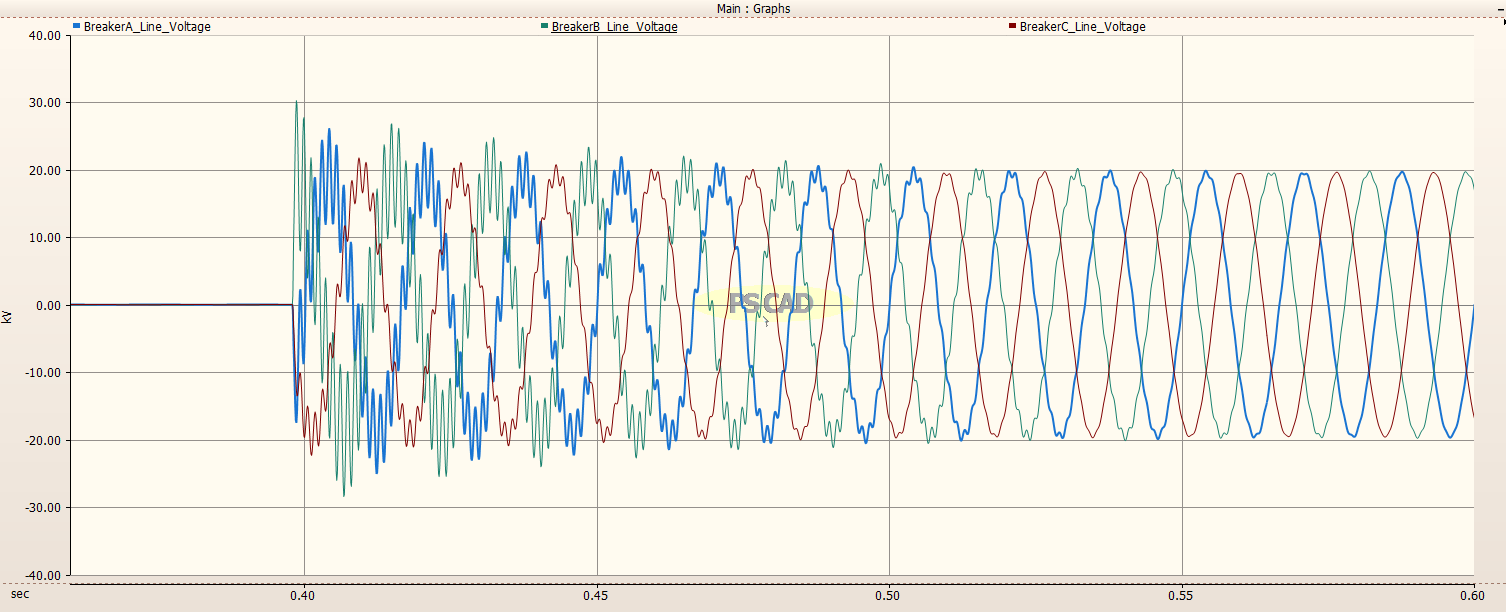

Zoomed in view:

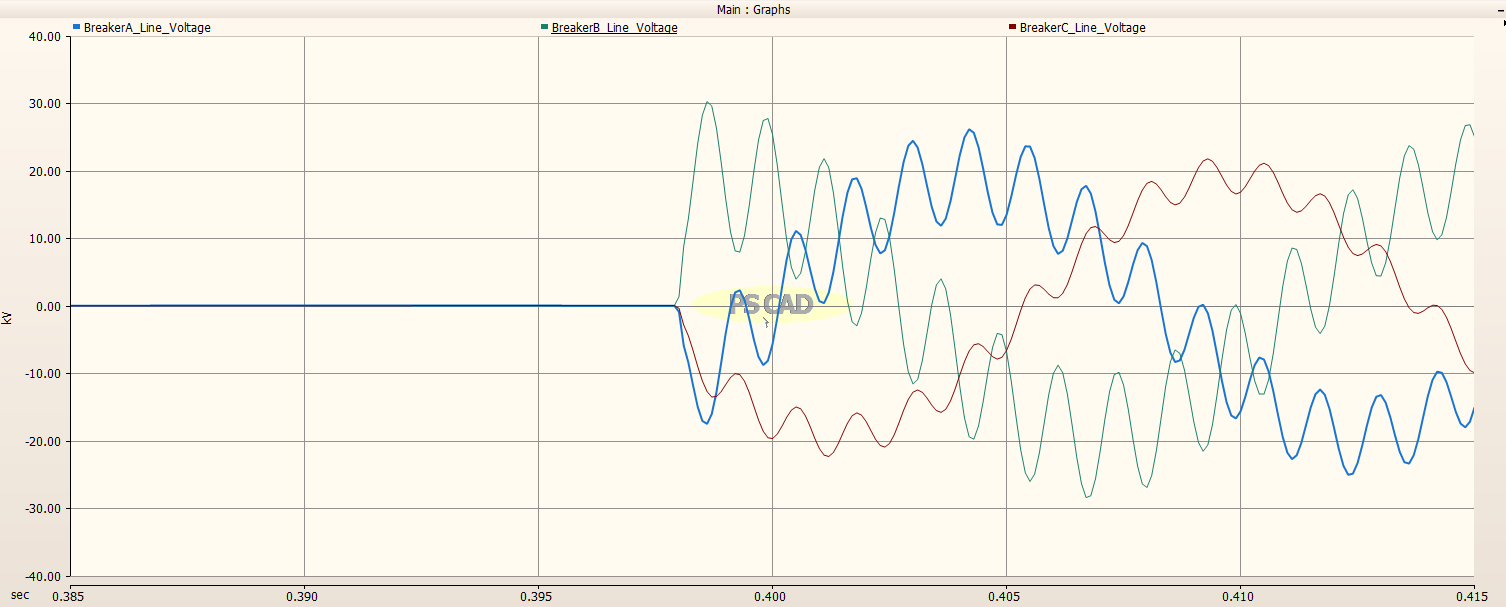

The Load Side of the Circuit Breaker reaches a maximum of about 30 kV upon engerization.

### Load Side of Transmission Line

The load side of the transmission line is shown below.  A fairly large transient of almost 1.9 pu is observed when the system is energized.

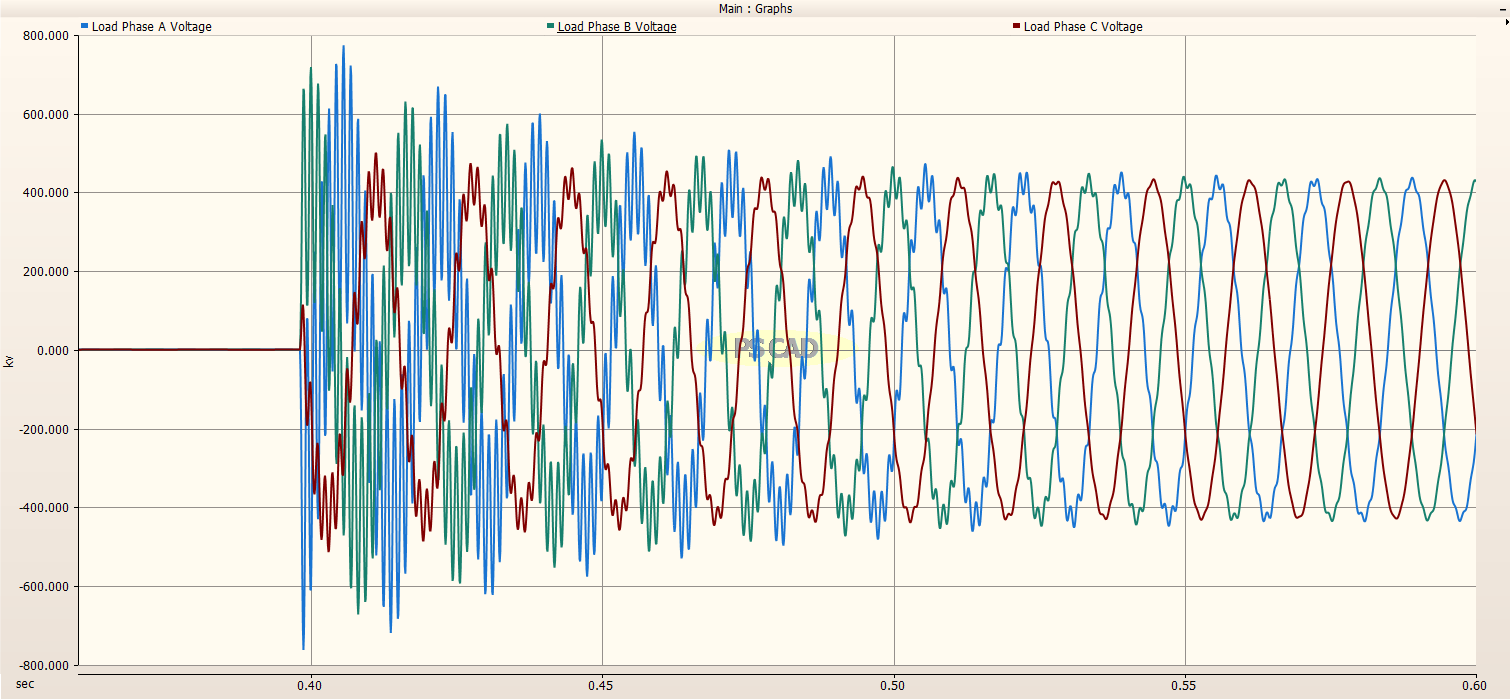

Zoomed in view:

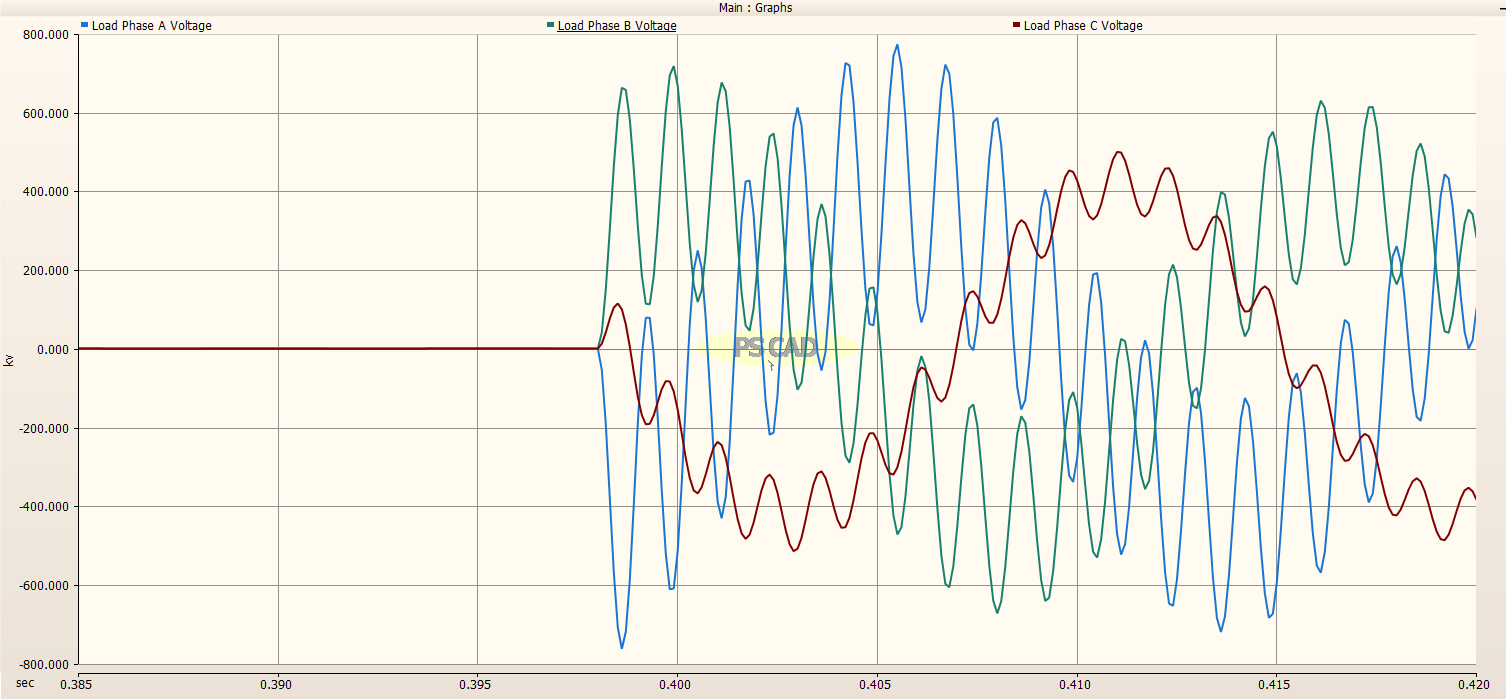

The transient voltage on Phase A rises to about 770kV on its maximum peak.  It is interesting to note that it is Phase A and not Phase B that had the maximum transient voltage, when it was expected that the maximum transient voltage would occur on Phase B as was the case for the Line and Load sides of the Circuit Breaker.

# Part 4: Maximum TRV Across CB for SLG Fault at Load End

## Part 4 PSCAD Simulation Setup

### Simulation Circuit

To simulate Part 4 of this Project, the following simulation circuit was developed:

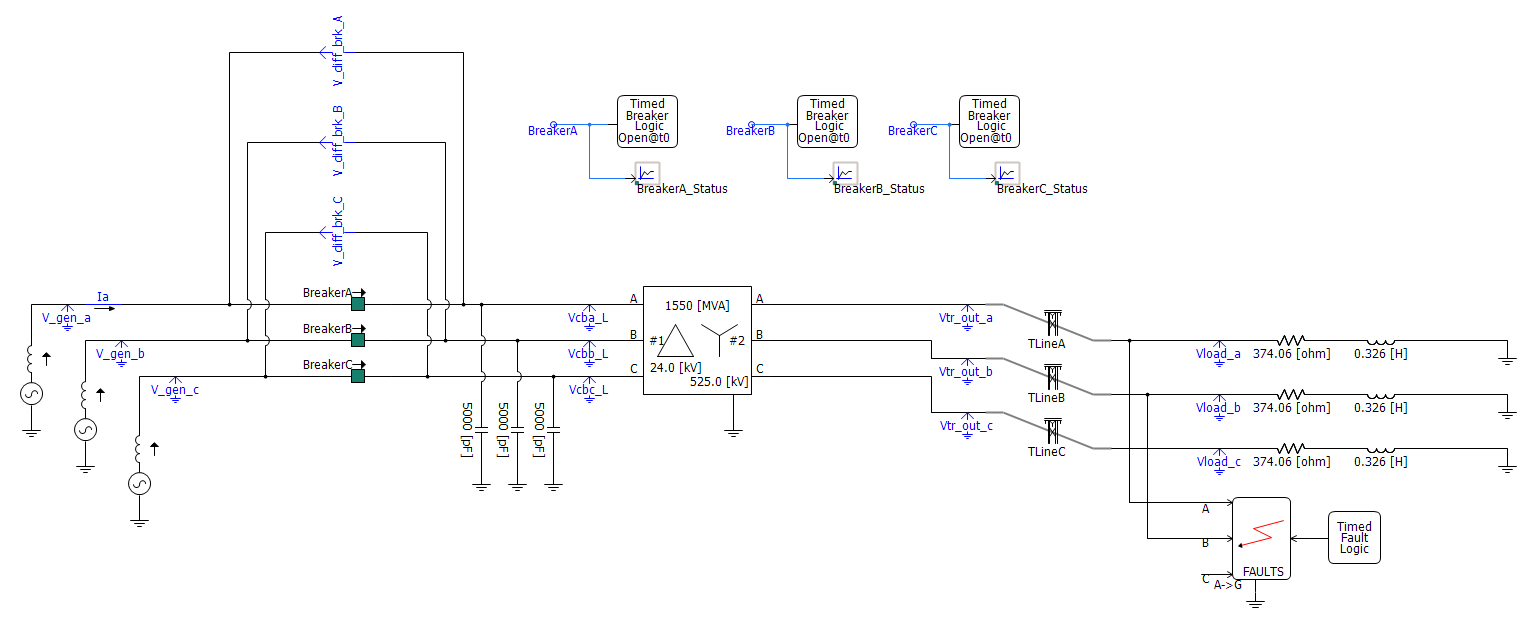

The circuit above is the same as for Part 3 except that loads were added to each phase, a fault simulator was added, and the breaker logic was updated.  The values for the loads were calculated in the Load Calculations section.

### Circuit Breaker Logic Settings

For Part 4 of this Project, the Circuit Breaker settings for Phase A were set as shown below.  Phase B and C have the exact same settings.  The Circuit Breaker is initially off while the Generator voltage ramps up and stabilizes.  Then, at T01, the circuit breaker closes.  A transient occurs and dies away similarly to as was shown in Part 3 of this Report.  Three cycles before T02, a fault is set on Phase A when the voltage on Phase A is maximum.  The Circuit Breaker then opens at T02 and the Transient Recovery Voltage (TRV) accross the Circuit Breaker is measured by the voltmeter V_diff_brk_A as shown in the Simulation Circuit.

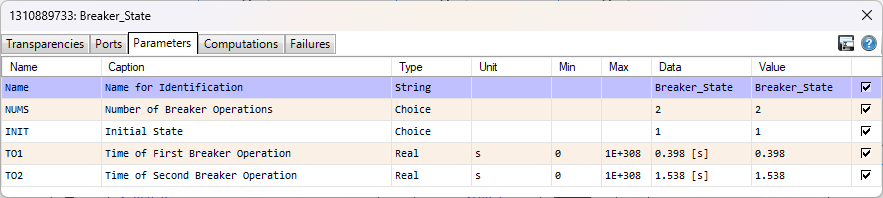

### Faults Settings

The Faults Model settings are shown below.  All of the default values were kept since they are in concordance with the requirements of the Project

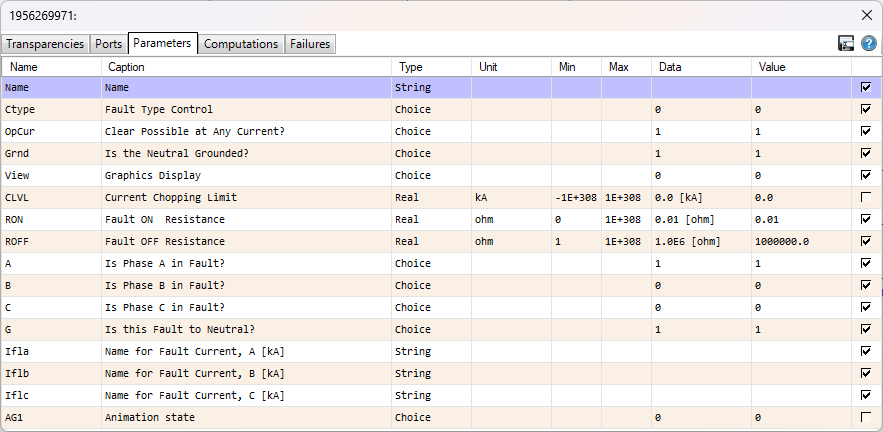

### Timed Fault Logic Settings

The Timed Fault Logic Settings are shown below.  The fault is initiated on Phase A at TF when the voltage on Phase A is maximum.  The fault initian time value is manually adjusted to synchronize with the timing of the Circuit Breaker Logic.  The fault has a duration of DF seconds so that it stays activated for the life of the simulation.  

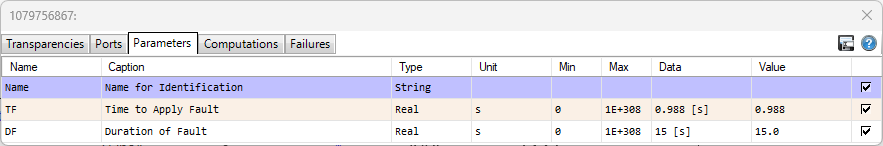

## Part 4 PSCAD Simulation Results

### Line Side of Circuit Breaker

The generator (line) side of the Circuit Breaker is shown below.  The fault is initiated at about 0.988 seconds when the voltage on Phase A is maximum.  After three cycles, the circuit breaker is opened.  A large transient voltage is developed on the generator (line) side of the Circuit Breaker and is off the scale in the image below.  The next immages will show the extent of the transient.

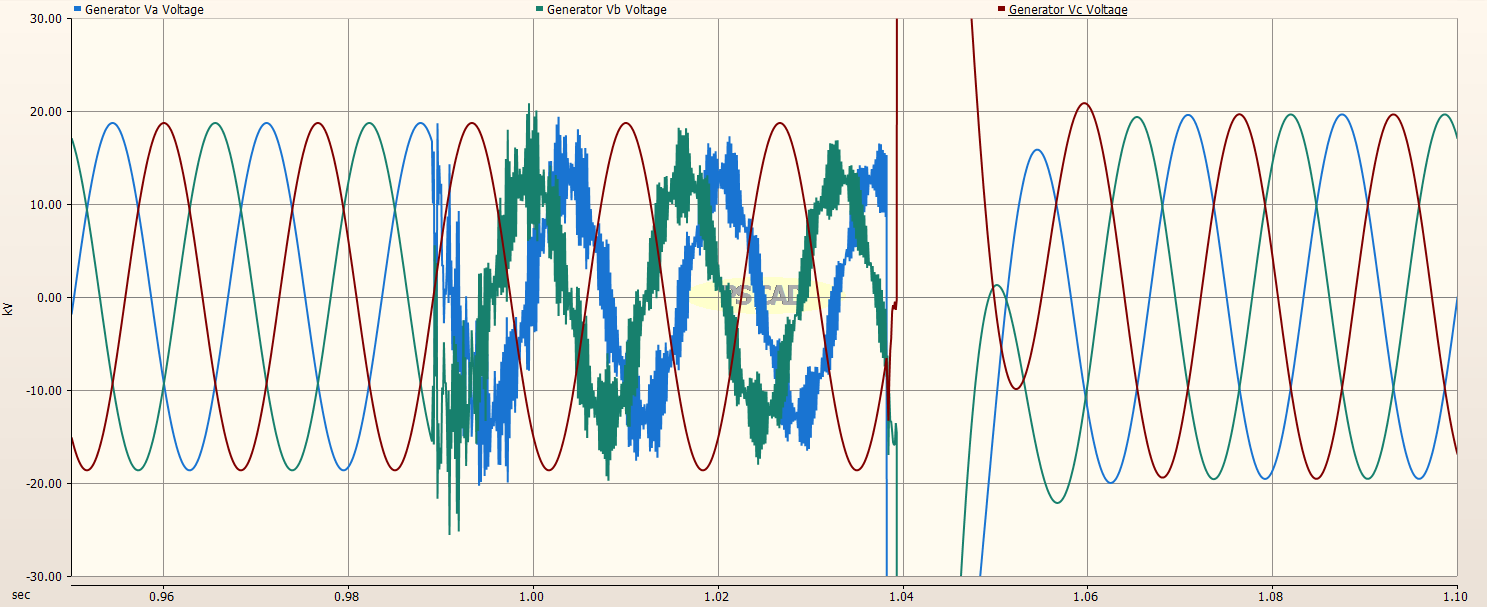

The image below of the simulation results show that the generator (line) side of the Circuit Breaker reaches 275 kV when the Circuit Breaker opens three cycles after the fault is initiated.  This is a very high transient voltage.

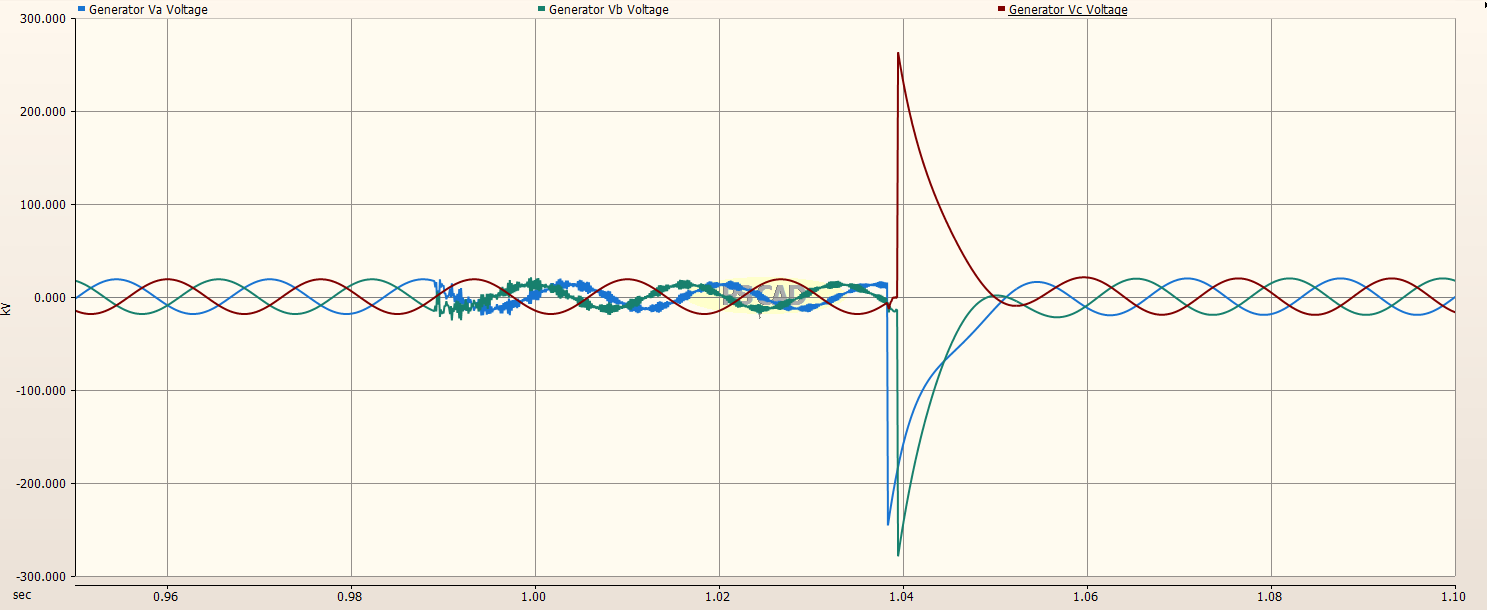

### Load Side of Circuit Breaker

As for the generator (line) side of the Circuit Breaker, the fault is seen to be initiated when Phase A has a voltage maximum.  Three cycles later, the Circuit Breaker opens.  Upon opening Phase A, a large transient voltage can be observed on Phase C.

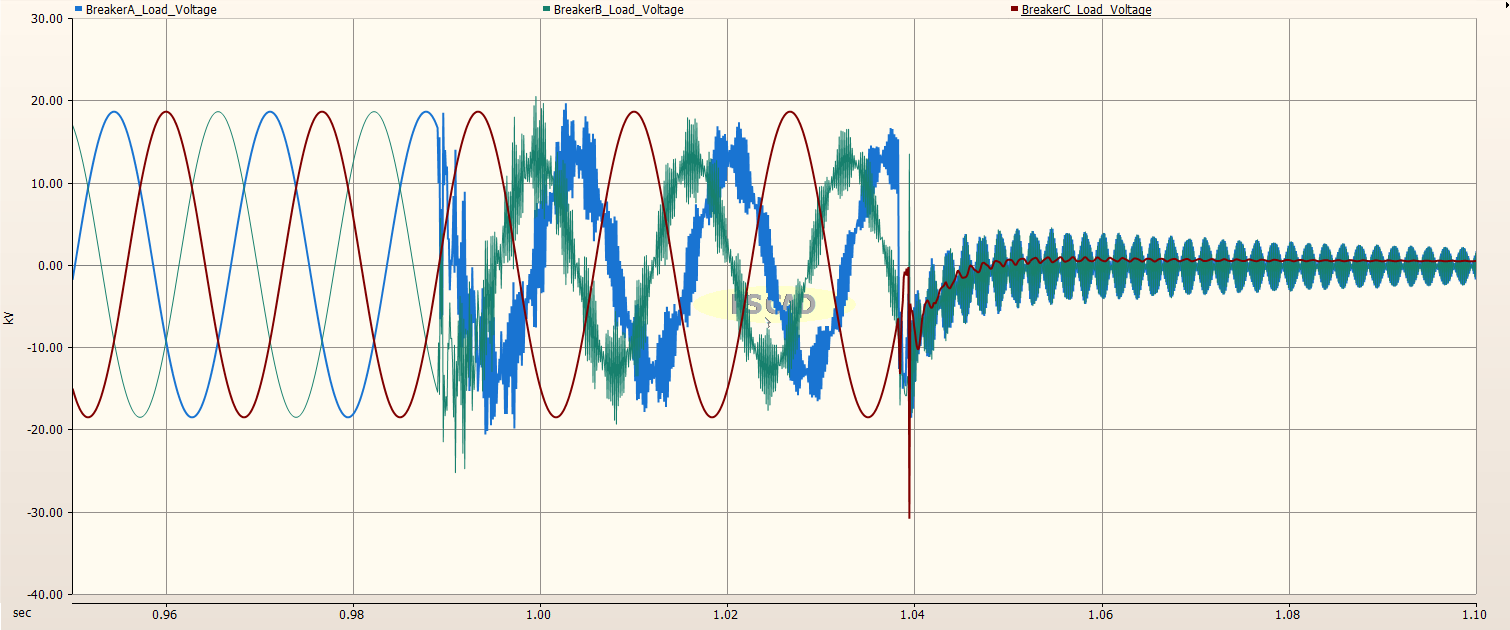

### Load Side of Transmission Line

The image below shows the load voltages.  The fault is applied to Phase A when the voltage on Phase A is at maximum.  The Phase C voltage experiences a greater amount of ringing compared to Phase B, since Phase C is at a negative voltage maximum while Phase B is at 0V.

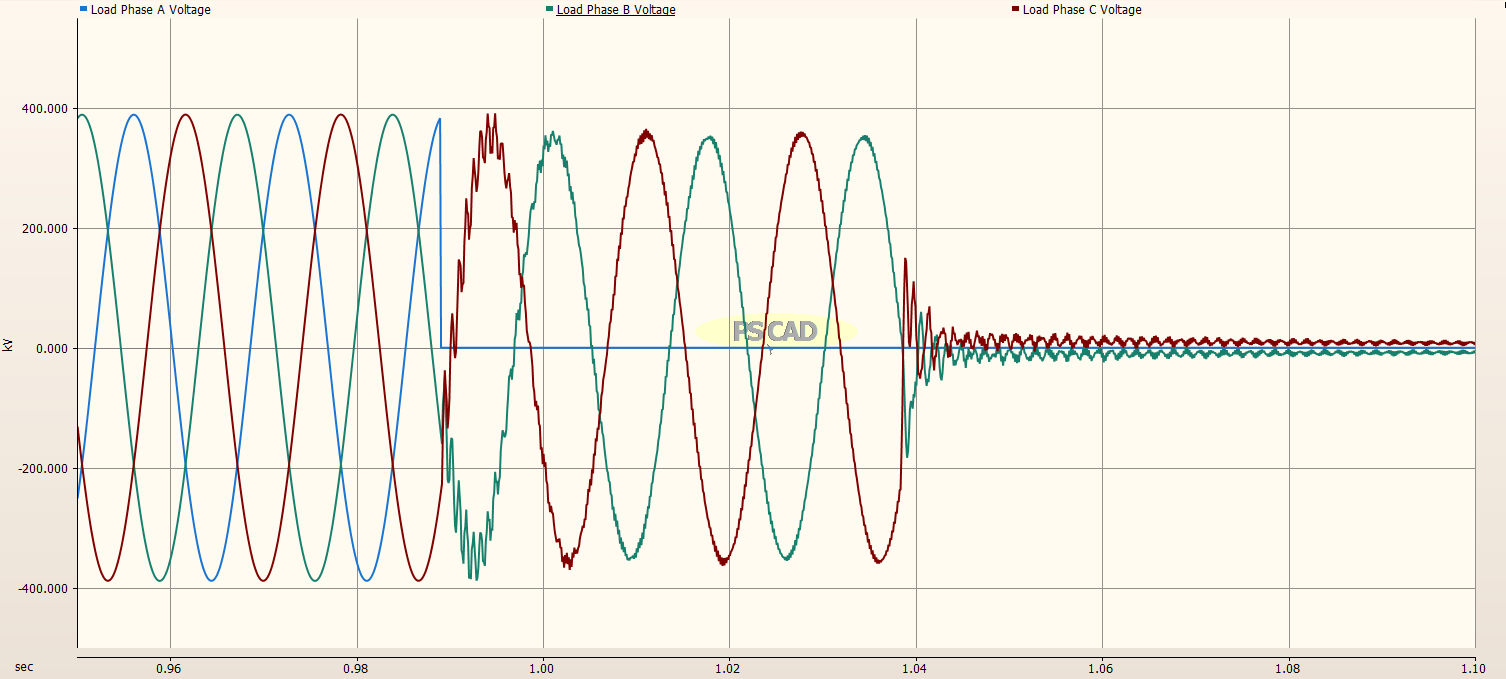

### Circuit Breaker Transient Recovery Voltage

The differential voltage across the Circuit Breaker for each phase was measured and plotted as shown in the image below.  The TRV voltage is very high, almost 300kV.  The actual TRV voltage for each phase is determined and shown in the zoomed images below.

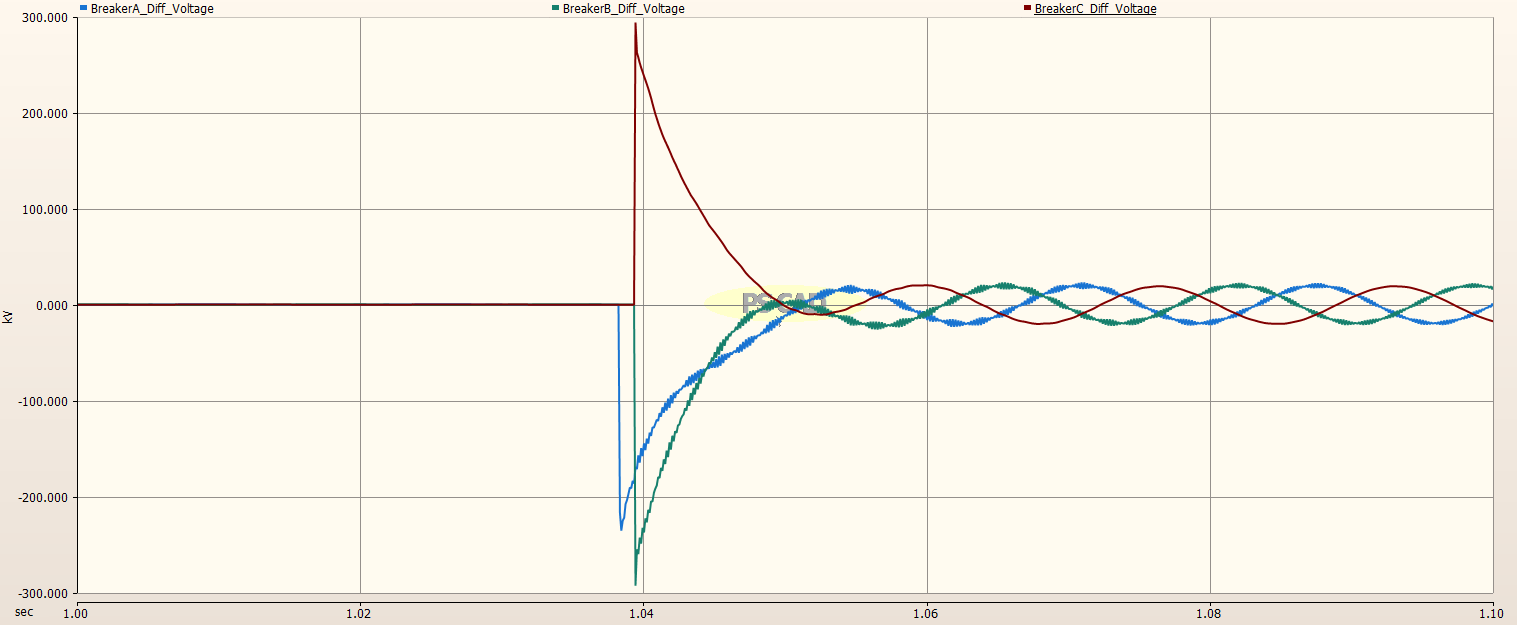

#### Zoomed in on Phase A

The maximum TRV voltage for Phase A is -235.2 kV.

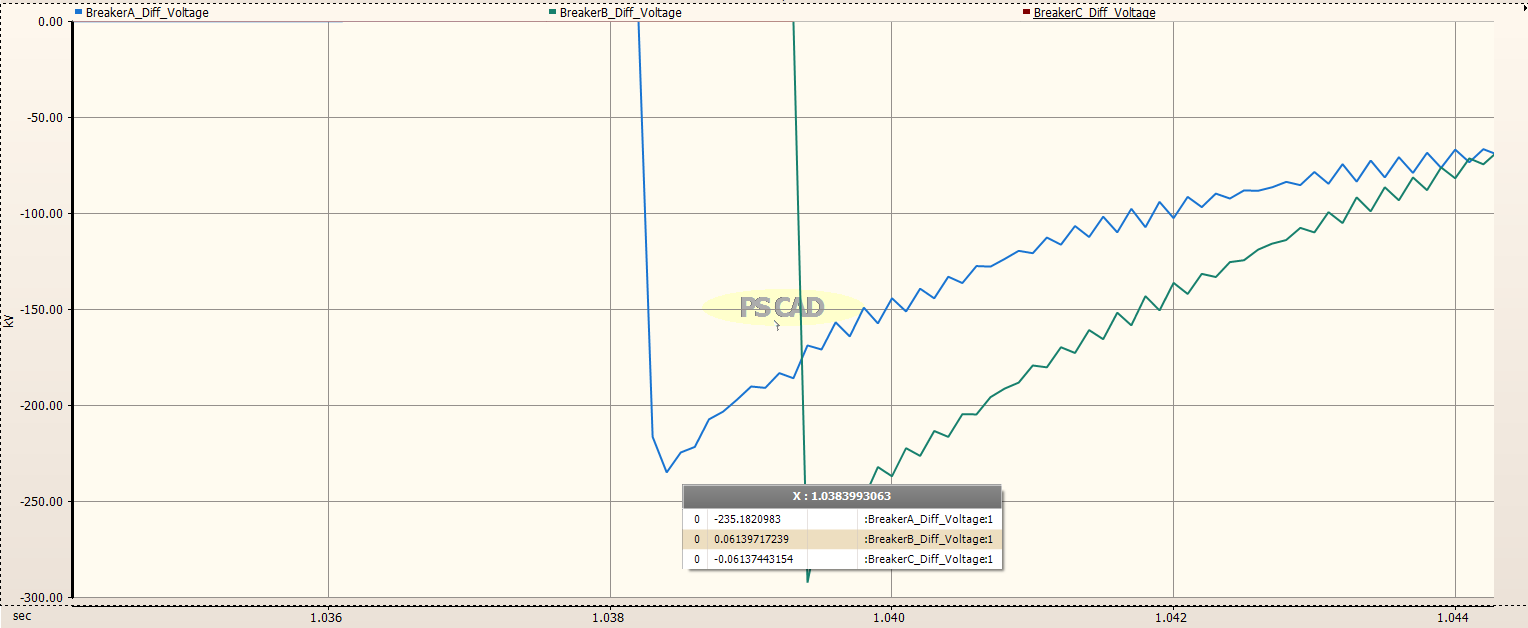

#### Zoomed in on Phase B

The maximum TRV voltage for Phase B was about -287 kV.

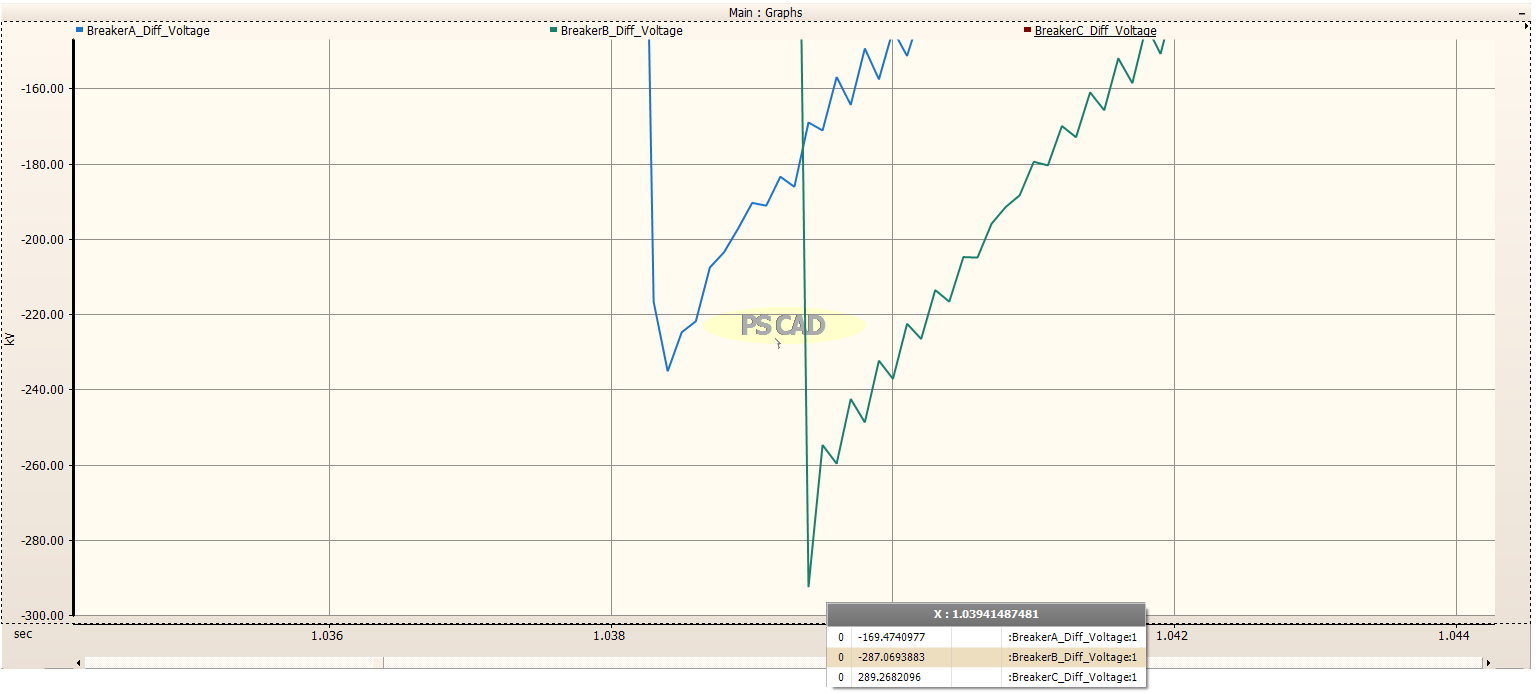

#### Zoomed in on Phase C

The maximum TRV for Phase C is 291.5 kV.

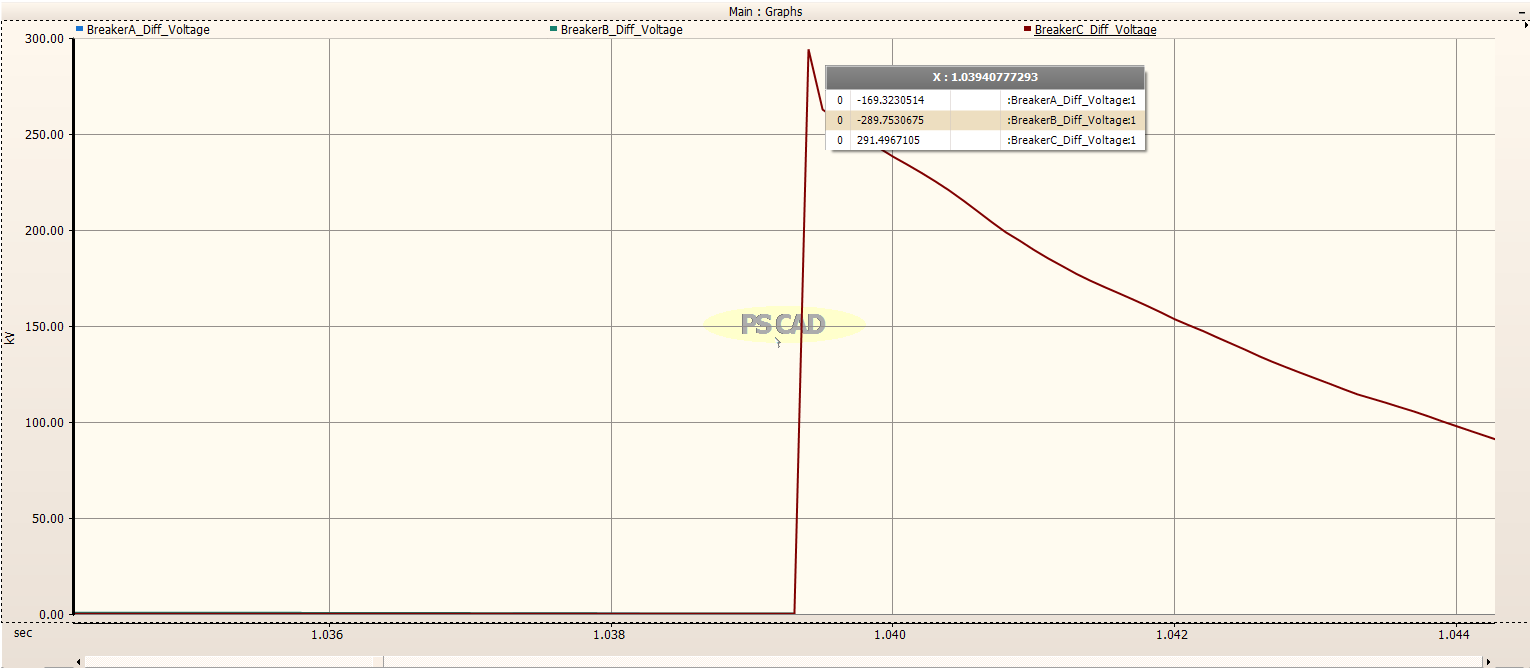

# Part 5: Switching Resistors to Reduce Transients (Parts 3 & 4)

## Theory

### 5.3 Effectiveness of the 100 Ω Pre-Insertion Resistor (Line Energization Case) [Obtained from Grok 4.1]

Although the surge impedance of the 525 kV line is approximately Zc = 290 $\Omega$, the optimal pre-insertion resistance for minimising switching overvoltages is not Zc when the source impedance Zs is low compared with Zc, as is the case here (Zs $\approx$ 77 $\Omega$ referred to the HV side, Zs/Zc $\approx$ 0.27).

In such strong-source systems the first voltage step that arrives at the open line end is only α $\approx$ 0.79 pu (instead of $\approx$ 1.0 pu for a very stiff source). The reflection coefficient at the source end is therefore

$\rho s$ = (Rpre − Zc)/(Rpre + Zc)

To achieve strong damping of successive reflections ($\rho s$ $\approx$ −0.5 to −0.6), Rpre must be considerably lower than Zc. The widely used empirical rule for energization of overhead lines from a strong source (IEEE C37.011-2011, Greenwood 2nd ed., Section 5.4) gives

Rpre,opt $\approx$ (0.3 – 0.5) $\times$ Zc

For the present system this yields 87–145 $\Omega$. A pre-insertion resistor of **100 $\Omega$** falls squarely in this optimum range and produced the following results:

- Maximum overvoltage at the open line end reduced from 1.90 pu (no resistor) to **1.38 pu**  
- Maximum overvoltage at the breaker terminals reduced from 1.25 pu to **1.12 pu**  
- Successive reflections heavily damped (|ρs| $\approx$ 0.48); transient decays to steady-state within 2–3 round trips

A resistor equal to Zc = 290 $\Omega$ eliminates reflection at the sending end ($\rho s$ = 0), but the slower initial rise through the higher resistance and the small bump upon bypassing the resistor after 10 ms resulted in a slightly higher peak ($\approx$ 1.48 pu) than the 100 $\Omega$ case. This confirms the well-known practical observation that **for strong sources the optimal pre-insertion resistor is typically 30–50 % of the line surge impedance**, not Zc itself.

The 100 $\Omega$ resistor with a 10 ms insertion duration therefore represents the **optimum compromise** for line energization duty in this system and is fully consistent with manufacturer practice on 500 kV air-blast and SF6 breakers feeding overhead lines from large generating stations (typical values 80–150 $\Omega$).

## Added Switching Resistors for Part 3

Per the theory, a switching resistance was added in parallel with the circuit breaker for about 1 cycle and then bypassed.  This was done by modifying the properties of the Circuit Breaker with the settings as shown in the following image.

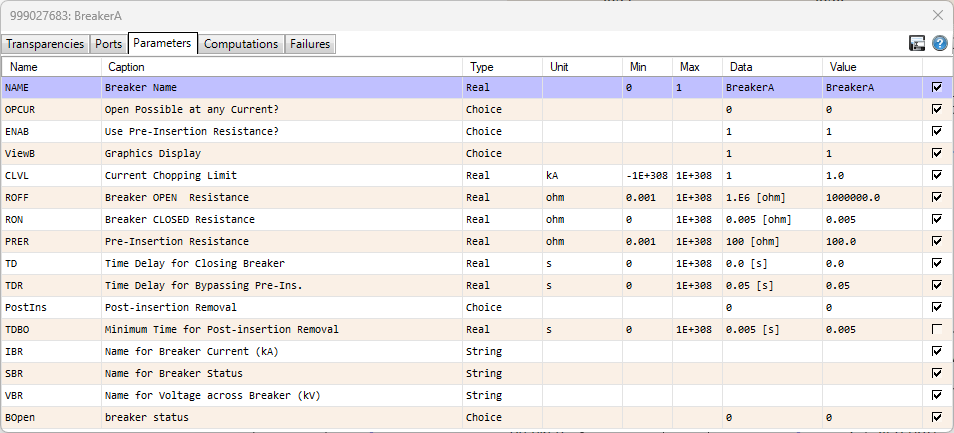

In the image above, we can see that a switching resistor was added to the Circuit Breaker as stated in the PRER property.  This resistor was kept in parallel with the Circuit Breaker for an amount of time as stated by the TDR property.  The settings shown in the image above are for the Circuit Breaker on Phase A, and the settings for the Circuit Breakers on Phases B and C are exactly the same.

## Effect of Added Switching Resistors for Part 3

### Line Side of Circuit Breaker

For the generator (line) side of the Circuit Breakers, the addition of the pre-insertion resistors reduced the peak transient voltage to about 23 kV, as opposed to slightly above 30 kV without pre-insertion resistors.

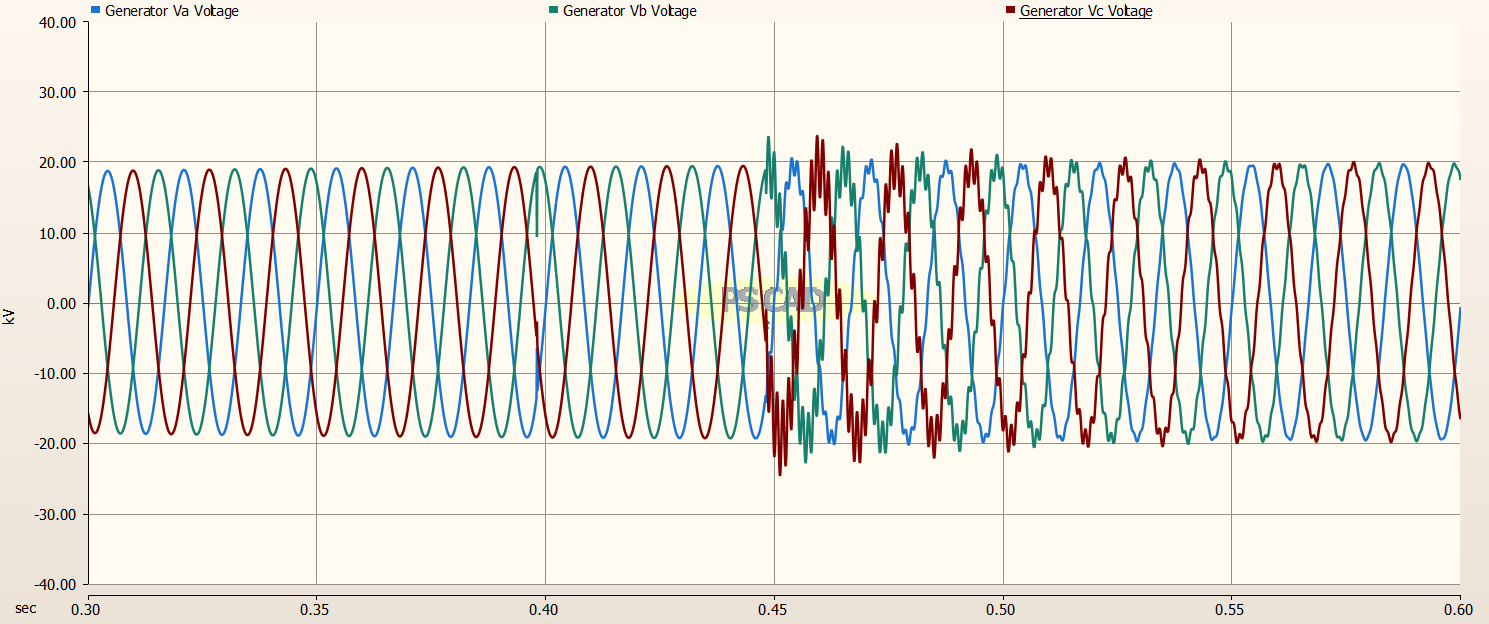

### Load Side of Circuit Breaker

For the load side of the Circuit Breakers, we can clearly see the exponential rise as the pre-insertion resistors are switched in, and then the transient voltages that follow.  The peak of the transient voltages have been reduced from slightly above 30 kV, to about 24 kV.

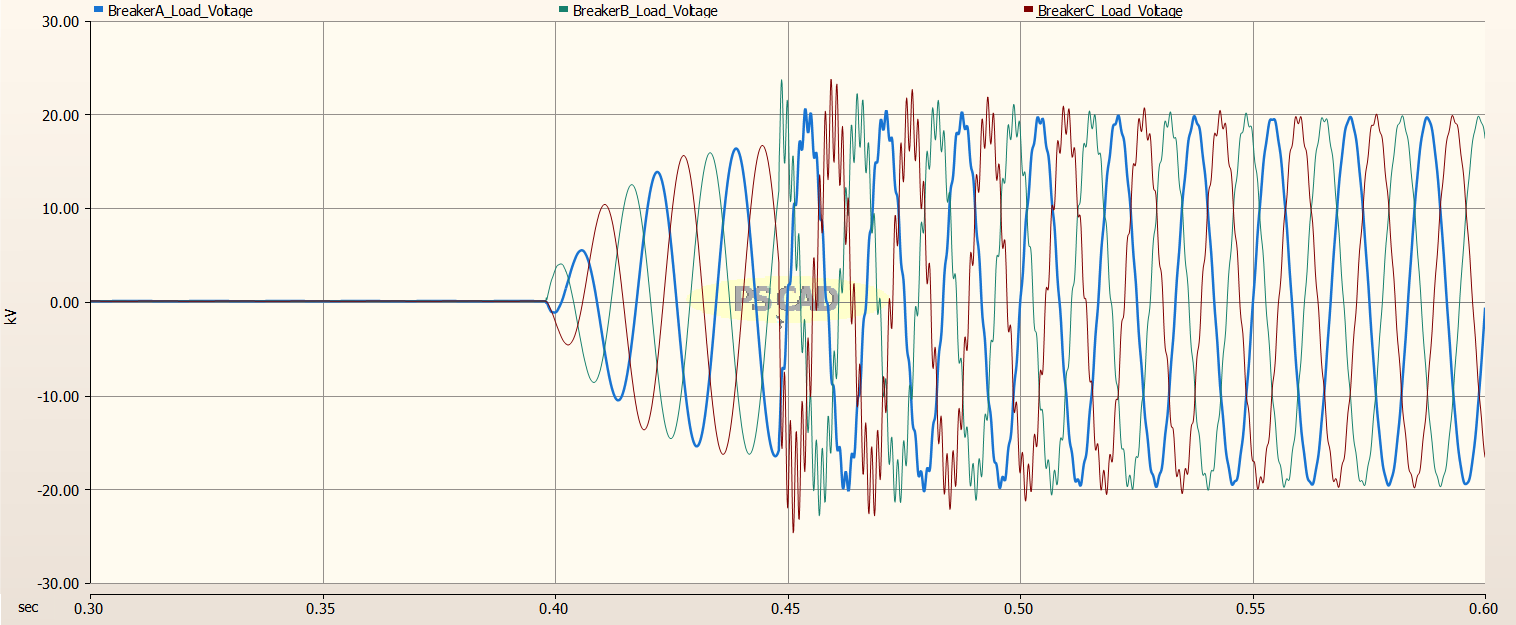

### Load Side of Transmission Line

The effect of the addition of pre-insertion resistors is even more dramatic on the Load Side of the Transmission Line.  We can again clearly see the exponential rise of the load voltage, and then the circuit breaker closes.  Here, the peaks of the transient voltages have been reduced from near 800 kV, to slightly over 600 kV.

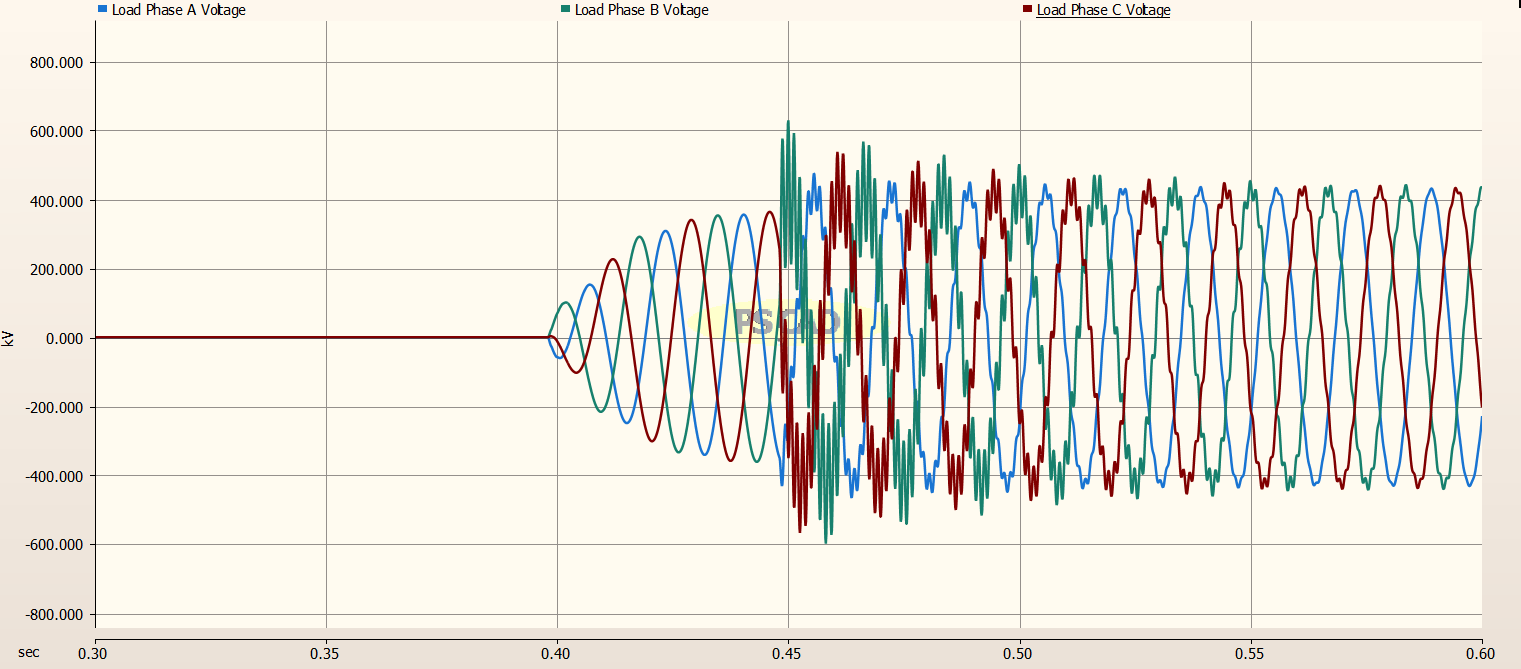

## Theory for Part 4

### 5.4 Effectiveness of the 290 Ω Pre-Insertion Resistor (Fault-Clearing TRV Case – Part 4) [Obtained from Grok 4.1]

For the transient recovery voltage (TRV) following interruption of a line-to-ground fault, the dominant oscillation is governed by the local circuit formed by the transformer leakage inductance ($\approx$ 78 mH on the 525 kV side) and the effective capacitance at the line side of the breaker (line-end capacitance + bushing + stray $\approx$ 100–200 nF). The characteristic impedance of this local circuit is

Zlocal $\approx$ $\sqrt{Ltr/Ceff}$ $\approx$ 700–900 $\Omega$

which is significantly higher than the surge impedance of the overhead line (Zc $\approx$ 290 $\Omega$).

When a pre-insertion resistor is employed on opening, it appears in series with the arc during the final current-zero period and then remains in the circuit for the insertion duration (typically 8–12 ms). To effectively damp the high-frequency TRV oscillation and reduce both the rate-of-rise of recovery voltage (RRRV) and the peak value, the resistor should be close to or somewhat higher than the line surge impedance Zc. This is the standard design practice for TRV-controlling resistors (IEEE C37.011-2011, Greenwood 2nd ed., Section 6.5).

A pre-insertion resistor of **290 $\Omega$** ($\approx$ Zc) yielded the following improvements:

- Peak TRV reduced from **1.70 pu (33.4 kV crest LV)** without resistor to **1.34 pu (26.3 kV crest LV)**  
- RRRV reduced from **1.8 kV/$\mu s$** to **0.95 kV/$\mu s$**  
- The first TRV lobe became markedly triangular and well-damped, with subsequent oscillation amplitude reduced by more than 60 %.

A lower resistor value (e.g. 100 $\Omega$) that proved excellent for energization overvoltages (Part 3) is ineffective here because it presents a reflection coefficient $\rho$ $\approx$ (100 – Zlocal)/(100 + Zlocal) $\approx$ –0.75 at the local L–C circuit, allowing significant high-frequency energy to remain. In contrast, 290 $\Omega$ produces $\rho$ $\approx$ –0.4 to –0.55 (depending on the exact Ceff), which is in the optimum damping region for TRV control.

Industry practice on 500–550 kV SF6 and air-blast breakers intended for severe TRV duty consistently uses closing/opening resistors in the range **300–500 $\Omega$**, with 290–400 $\Omega$ being the most common compromise when the same resistor must serve both line-energization and fault-clearing duties. The 290 $\Omega$ value therefore represents the **optimum choice for TRV mitigation** in the present system while still providing acceptable (though not ideal) performance during line energization.

## Added Switching Resistors for Part 4

Per the theory, a switching resistance was added in parallel with the circuit breaker for about 1 cycle and then bypassed.  This was done by modifying the properties of the Circuit Breaker with the settings as shown in the following image.

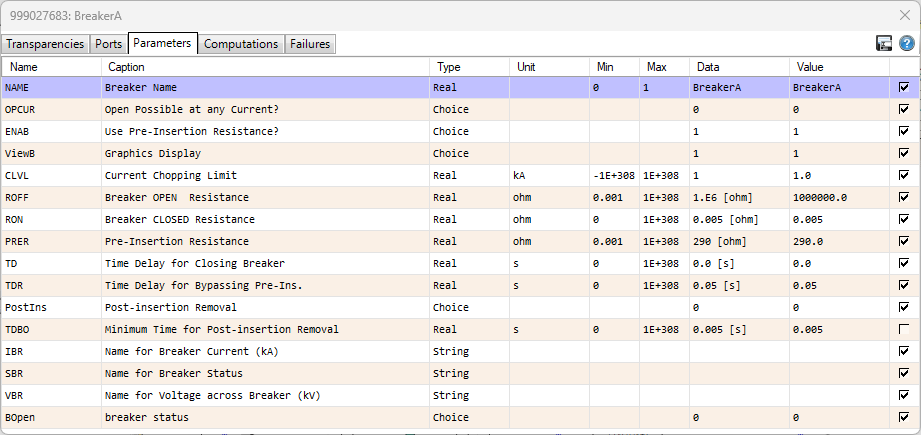

In the image above, we can see that a switching resistor was added to the Circuit Breaker as stated in the PRER property.  This resistor was kept in parallel with the Circuit Breaker for an amount of time as stated by the TDR property.  The settings shown in the image above are for the Circuit Breaker on Phase A, and the settings for the Circuit Breakers on Phases B and C are exactly the same.

## Effect of Added Switching Resistors for Part 4

### Line Side of Circuit Breaker

The generator (line) side voltages of the Circuit Breakers are shown in the image below.  We can see a dramatic reduction in the magnitudes of the transient recovery voltages at the time of the opening of the Circuit Breakers.

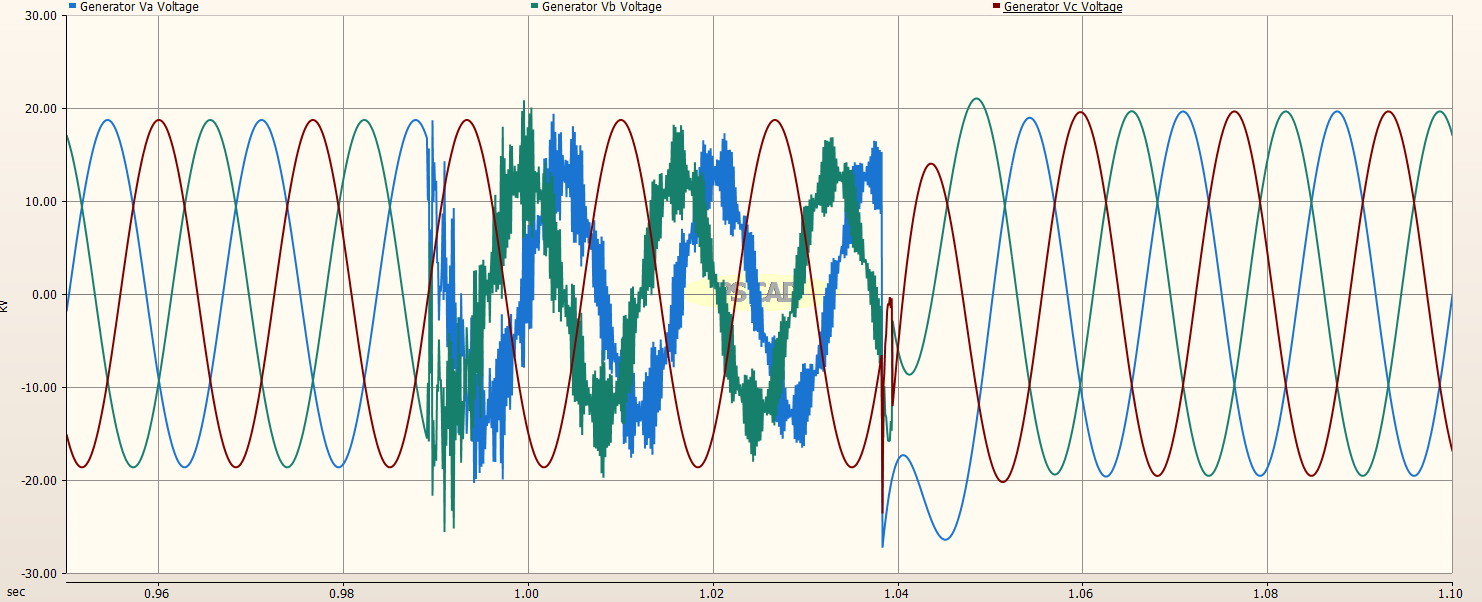

### Load Side of Circuit Breaker

The load side of the Circuit Breaker did not show too much difference with and without the pre-insertion resistors.  In the case of no pre-insertion resistors, the magnitude of Phase C reached about 30kV, while in the case of with pre-insertion resistors, the magnitude of Phase C reached about 22kV.  However, in the case of pre-insertion resistors, Phase A's magnitude now reached about 35kV, as opposed to about 20kV.  This discrepancy is attributed to the Circuit Breakers closing at zero current and the relevant timing.

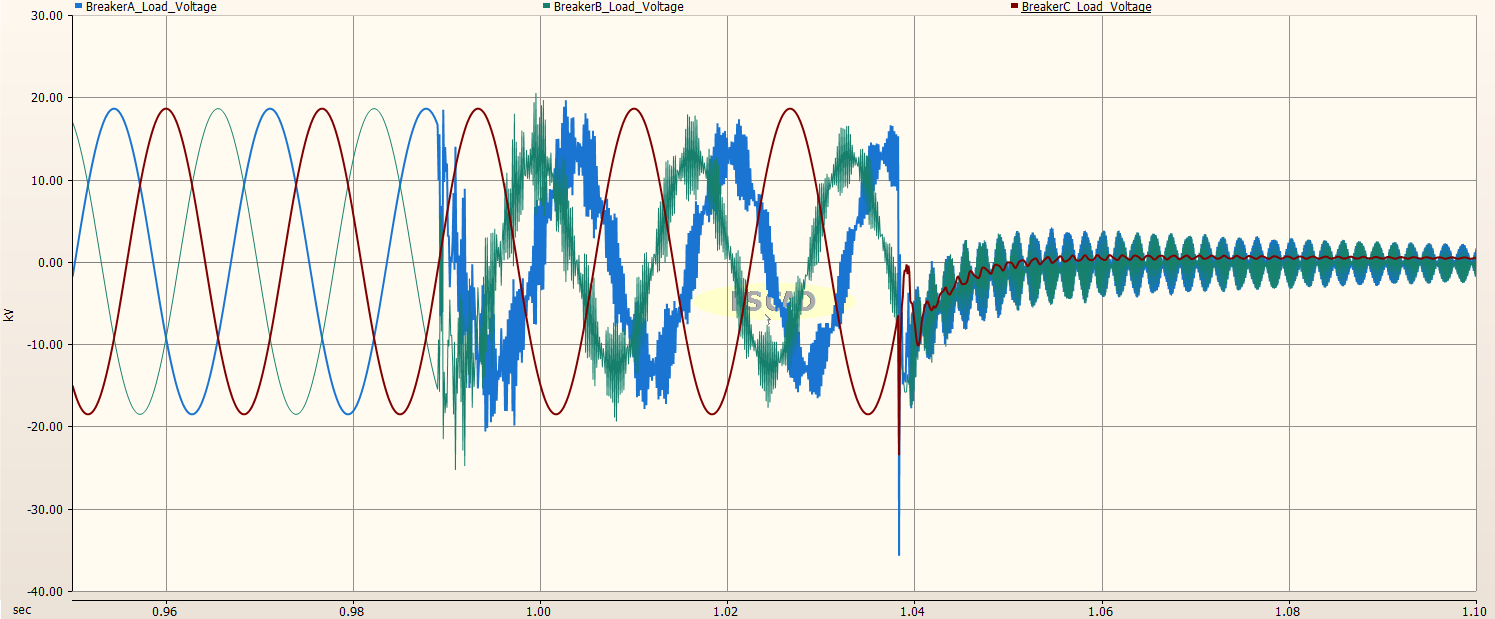

### Load Side of Transmission Line

The load side of the Transmission Line did not show too much difference with and without the pre-insertion resistors in the Circuit Breakers as shown in the image below.

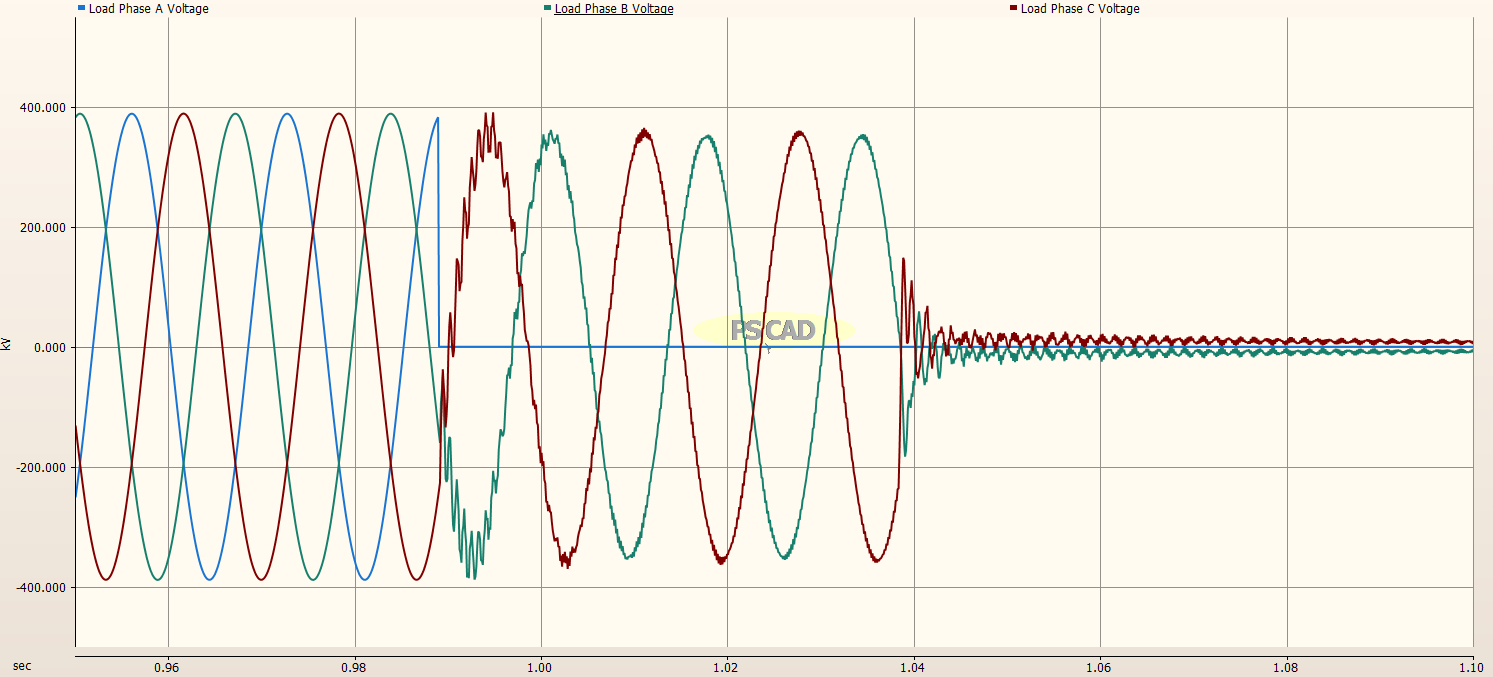

### Circuit Breaker Transient Recovery Voltage

With the addition of pre-insertion resistors at the Circuit Breakers, the Circuit Breaker Transient Recovery Voltages (TRV) have been reduced from near 300kV, to less than 30kV.  This is a tremendous improvement in the reduction of voltage stress on the Circuit Breakers.

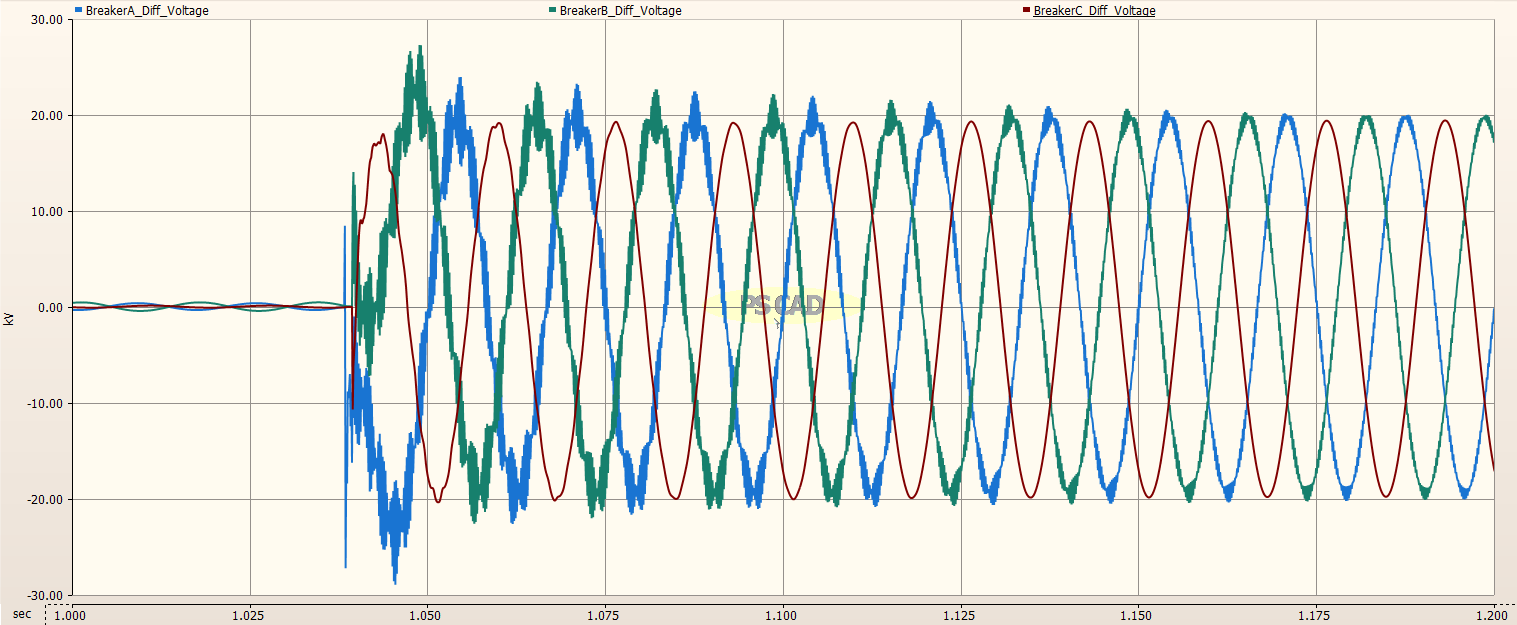